In [2]:
%matplotlib notebook
from quantum_builder import QuantumBuilder
import logging
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets
from matplotlib import cm
import qutip as qt
plt.style.use("support-files/qubit.mplstyle")

MY_COLOURS = {
    "DarkBlue": "#104e8b",     # dark blue (DodgerBlue4)
    "DarkRed": "#ed2200",     # dark red (red2)
    "Green": "#9acd32",     
    "Orange": "#ffc125",      # orange,
    "LightBlue": "#68838b",  # light steel blue,
    "Purple": "#6959cd",  # dark purple
    "Pink": "#ffa07a"  # pink salmon
}
GHz = 10**9
MHz = 10**6
fF = 10**(-15)
e = 1.6*10**(-19)
kOhm = 10**3
h = 6.64*10**(-34)
Phi0 = h/(2*e)
hbar = h/(2*np.pi)
nH = 10**(-9)
nF = 10**(-9)
kb = 1.38 * 10**(-23)
Rq = h/(4*e*e)
um = 10**(-6)
mF = 10**(-3)

# Resonators
Qubits will interact with different modes of the resonator.

The strength of the coupling will depend on this position:
\begin{equation}
 g = \frac{\pi{E_s}C_{q-r}}{2e}\sqrt{\frac{\hbar\omega_r}{C_r}}\cos(n\pi{\frac{x}{L}})
\end{equation}

- Cosine comes from the positon of the resonator
- $\sqrt{\frac{\hbar\omega_r}{C_r}}$ is the voltage in the resonator
- $C_{q-r}$ is the coupling capacitance between resonator and qubit
- $\frac{\pi{E_s}}{2e}$ is the voltage on the CQPS qubit associated with a phase slip event

## Position along resonator

<IPython.core.display.Javascript object>


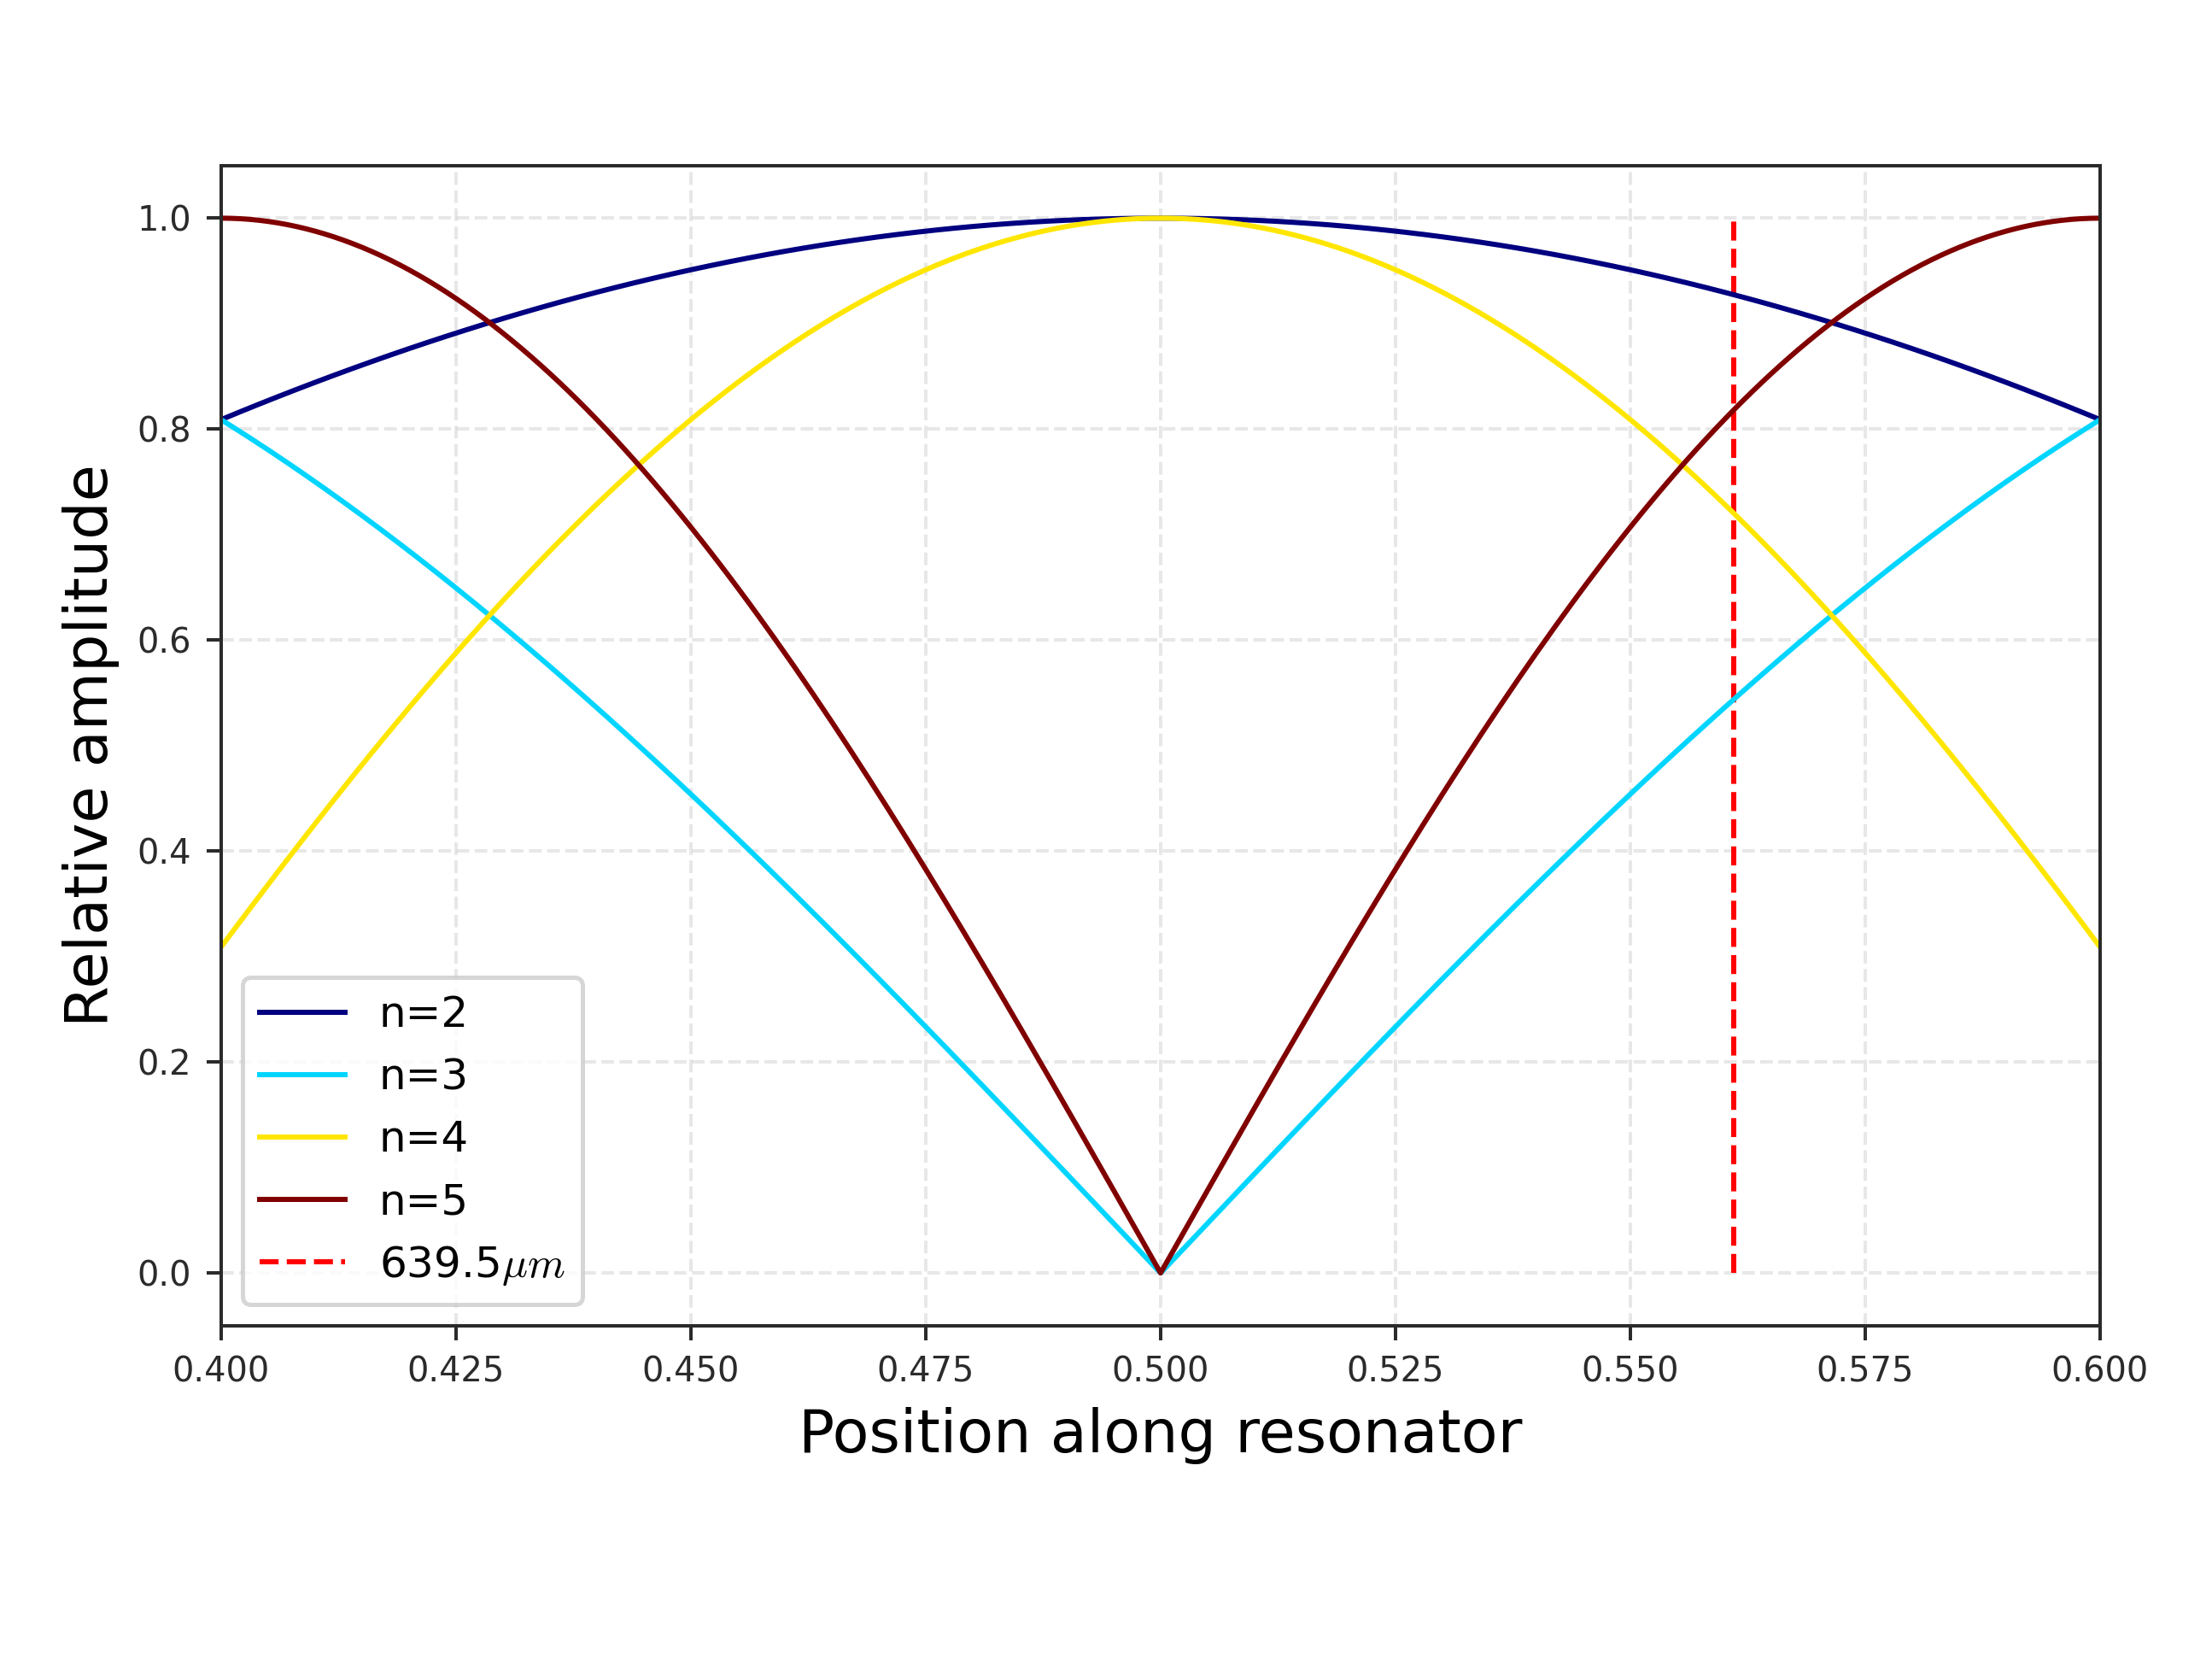

In [277]:
L = 1140
qubit_positions = [1/2 - 58/L, 1/2 + 69.5/L]
N = [2, 3, 4, 5]

def resonator_voltage_scaling(x: float, mode: int):
    "x is in units between 0 and 1"
    return np.abs(np.cos(mode * np.pi * x))
    

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
cm = plt.cm.jet(np.linspace(0, 1, len(N)))
x = np.linspace(0, 1, 1001)

# Plot voltage modes
for idx, n in enumerate(N):
    ax.plot(x, resonator_voltage_scaling(x, n), 
            color=cm[idx], label=f"n={n}")

# Plot qubit positions
# for q in qubit_positions:
#       ax.vlines(q, 0, 1, color="red", linestyles='--', label=f"{1140*q}$\mu{{m}}$")
ax.axvspan(qubit_positions[0], qubit_positions[1], color='red', alpha=0.1)
        
ax.set_xlim([0.4, 0.6])
ax.set_xlabel("Position along resonator")
ax.set_ylabel("Relative amplitude")
ax.legend()
plt.savefig("./output/cqps-resonator.pdf")

## Resonator Fitting

In [208]:
import scipy as sp
from scipy.optimize import curve_fit 

def fano_model(omega, 
               omega0,
               A,
               B,
               q, 
               gamma
              ):
    _var = 2 * (omega - omega0) / gamma
    return A + B * (q + _var)**2 / (1 + _var**2)

In [262]:
# Using velocity to find the sheet inductance

f = 1.57*GHz
L = 1140*um
velocity = 2 * L * f
# velocity/10**6

capacitance_per_unit_length = 0.85*10**(-10)
unit_length = 5*um

inductance_per_unit_length = 1 / velocity**2 / capacitance_per_unit_length

sheet_inductance = inductance_per_unit_length * unit_length

In [263]:
Z = np.sqrt(inductance_per_unit_length/capacitance_per_unit_length)
Z

3286.5979110383673

In [252]:
print(3.14/2)
print(5.13/3)
print(6.38/4)
print(7.95/5)

1.57
1.71
1.595
1.59


<IPython.core.display.Javascript object>


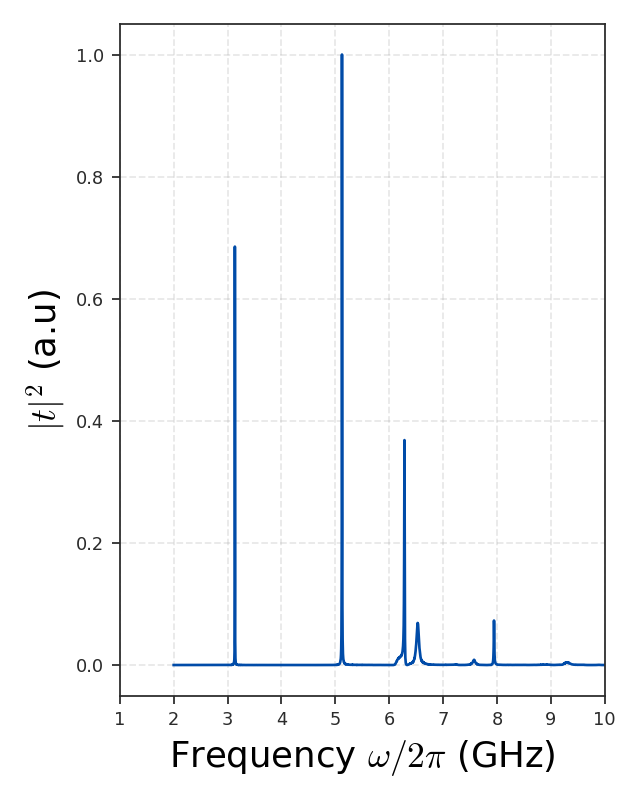

In [249]:
FILENAME="./data/2020-07_cqps-single/resonators/TiN95_CQPS_C_July12'20_res_01.txt"

data = np.loadtxt(FILENAME, skiprows=1)
data_x = data[:,0]/GHz
data_y = np.power((data[:,1]/max(data[:,1])), 2)
                       
fig, ax = plt.subplots(1, 1, figsize=(4, 5))
ax.plot(data_x, data_y/max(data_y))

ax.set_xlabel("Frequency $\omega/2\pi$ (GHz)", size=16)
ax.set_ylabel("$|t|^2$ (a.u)", size=16)
ax.set_xlim([1,10])
plt.tight_layout()

plt.savefig("./data/2020-07_cqps-single/resonators/full.svg")

## m2

[3.13674913e+00 1.12905571e+03 1.97715889e+00 1.01109372e+00]


<IPython.core.display.Javascript object>


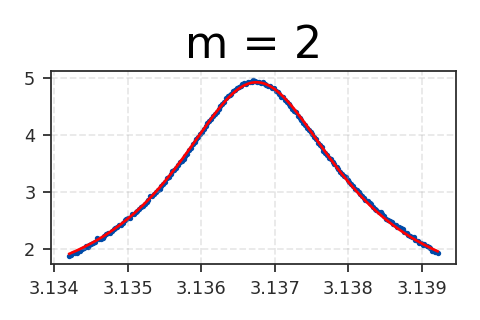

In [243]:
## Fitting resonator modes
## Raw data files: res01, cell Ay

FILENAME="./data/2020-07_cqps-single/resonators/m2.txt"

data = np.loadtxt(FILENAME, skiprows=1)
freq = data[:, 0]/GHz
Mag = data[:, 1]

## Lorentzian fit to obtain loaded Quality factor, Q_l

import scipy as sp
from scipy.optimize import curve_fit 

def _S21(f,fr,Ql,A,c):
       return A**2/(1.+4.*Ql**2*((f-fr)/fr)**2)+c
# Initial guess of the parameters (you must find them some way!)
pguess = [3.1368, 1511, 9,1]
# Fit the data, does not work
popt, pcov = curve_fit(_S21, freq, Mag, p0 = pguess, method='lm')
# Results
print(popt)

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.scatter(freq, Mag, marker="o", s=2, label='Data')
ax.plot(freq,_S21(freq, popt[0], popt[1], popt[2], popt[3]),'r',label='Fit') #plot fit
ax.set_title("m = 2")

# ax.set_xlabel("Frequency $\omega/2\pi$ (GHz)", size=16)
# ax.set_ylabel("$|t|^2$ (a.u)", size=18)
# ax.set_xlim([1,10])
plt.tight_layout()

plt.savefig(FILENAME.replace(".txt", ".svg"))

## m3

[ 5.12093712e+09  1.51763601e+00 -1.37522019e+00 -3.01265847e-03
 -7.99910582e+06]


<IPython.core.display.Javascript object>


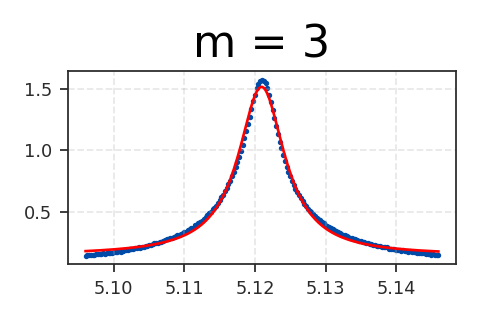

In [244]:
## Fitting resonator modes
## Raw data files: res01, cell Ay

FILENAME="./data/2020-07_cqps-single/resonators/m3.txt"

data = np.loadtxt(FILENAME, skiprows=1)
freq = data[:, 0]
Mag = data[:, 1]

def _S21(f,fr,Ql,A,c):
       return A**2/(1.+4.*Ql**2*((f-fr)/fr)**2)+c
# Initial guess of the parameters (you must find them some way!)
pguess = [5.121, 640, 1.17,0]
# Fit the data, does not work
# popt, pcov = curve_fit(_S21, freq[30:-30], Mag[30:-30], p0 = pguess, method='lm')
popt, pcov = curve_fit(fano_model, freq, Mag, p0 = [
    5.12*GHz, 
    1, 
    0.4, 
    0, 
    2*MHz])
# Results
print(popt)

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.scatter(freq/GHz, Mag, marker="o", s=2, label='Data')
ax.plot(freq/GHz, fano_model(freq, *popt),'r',label='Fit') #plot fit
ax.set_title("m = 3")

# ax.set_xlabel("Frequency $\omega/2\pi$ (GHz)", size=16)
# ax.set_ylabel("$|t|^2$ (a.u)", size=16)
# ax.set_xlim([5.1,5.14])
plt.tight_layout()

plt.savefig(FILENAME.replace(".txt", ".svg"))

## m4

[ 6.28468633e+09  2.96301996e+00 -2.12296409e+00 -1.62057014e-01
 -1.14146473e+07]
-11.41464727787845


<IPython.core.display.Javascript object>


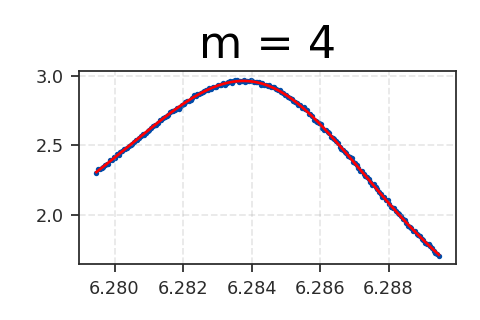

In [245]:

FILENAME="./data/2020-07_cqps-single/resonators/m4.txt"

data = np.loadtxt(FILENAME, skiprows=1)
freq = data[:, 0]
Mag = data[:, 1]

def _S21(f,fr,Ql,A,c):
       return A**2/(1.+4.*Ql**2*((f-fr)/fr)**2)+c
# Initial guess of the parameters (you must find them some way!)
pguess = [6.284, 1129, 2,0]
# Fit the data, does not work
# popt, pcov = curve_fit(_S21, freq[30:-30], Mag[30:-30], p0 = pguess, method='lm')
popt, pcov = curve_fit(fano_model, freq, Mag, p0 = [
    6.28*GHz, 
    1, 
    0.4, 
    0, 
    1*MHz])
# Results
print(popt)

print(popt[-1]/MHz)


fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.scatter(freq/GHz, Mag, marker="o", s=2, label='Data')
# ax.plot(freq,_S21(freq, popt[0], popt[1], popt[2], popt[3]),'r',label='Fit') #plot fit
ax.plot(freq/GHz, fano_model(freq, *popt),'r',label='Fit') #plot fit

ax.set_title("m = 4")
# ax.set_xlabel("Frequency $\omega/2\pi$ (GHz)", size=16)
# ax.set_ylabel("$|t|^2$ (a.u)", size=16)
plt.tight_layout()

plt.savefig(FILENAME.replace(".txt", ".svg"))

## m5

[7.94606750e+09 2.99036905e-01 2.13847959e-04 6.87031131e+01
 1.43029156e+07]


<IPython.core.display.Javascript object>


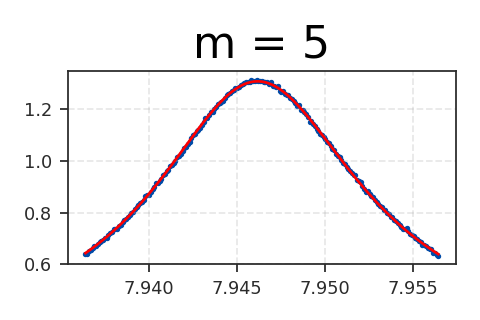

14.3029156448318


In [237]:
FILENAME="./data/2020-07_cqps-single/resonators/m5.txt"

data = np.loadtxt(FILENAME, skiprows=1)
freq = data[:, 0]
Mag = data[:, 1]

def _S21(f,fr,Ql,A,c):
       return A**2/(1.+4.*Ql**2*((f-fr)/fr)**2)+c
# Initial guess of the parameters (you must find them some way!)
pguess = [6.284, 1129, 2,0]
# Fit the data, does not work
# popt, pcov = curve_fit(_S21, freq[30:-30], Mag[30:-30], p0 = pguess, method='lm')
popt, pcov = curve_fit(fano_model, freq, Mag, p0 = [
    7.94*GHz, 
    1, 
    0.4, 
    0, 
    1*MHz])
# Results
print(popt)


fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.scatter(freq/GHz, Mag, marker="o", s=2, label='Data')
# ax.plot(freq,_S21(freq, popt[0], popt[1], popt[2], popt[3]),'r',label='Fit') #plot fit
ax.plot(freq/GHz, fano_model(freq, *popt),'r',label='Fit') #plot fit
ax.set_title("m = 5")
print(popt[-1]/MHz)

# ax.set_xlabel("Frequency $\omega/2\pi$ (GHz)", size=16)
# ax.set_ylabel("$|t|^2$ (a.u)", size=16)
plt.tight_layout()

plt.savefig(FILENAME.replace(".txt", ".svg"))

## Original fitting

In [ ]:
## Fitting resonator modes
## Raw data files: res01, cell Ay

FILENAME="./data/2020-07_cqps-single/resonators/m4.txt"

data = np.loadtxt(FILENAME, skiprows=1)
freq = data[:, 0]/GHz
Mag = data[:, 1]

def _S21(f,fr,Ql,A,c):
       return A**2/(1.+4.*Ql**2*((f-fr)/fr)**2)+c
# Initial guess of the parameters (you must find them some way!)
pguess = [5.121, 640, 1.17,0]
# Fit the data, does not work
popt, pcov = curve_fit(_S21, freq[30:-30], Mag[30:-30], p0 = pguess, method='lm')
# Results
print(popt)


fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.scatter(freq, Mag, marker="o", s=2, label='Data')
ax.plot(freq,_S21(freq, popt[0], popt[1], popt[2], popt[3]),'r',label='Fit') #plot fit

ax.set_xlabel("Frequency $\omega/2\pi$ (GHz)", size=16)
ax.set_ylabel("$|t|^2$ (a.u)", size=16)
ax.set_xlim([5.1,5.14])
plt.tight_layout()

plt.savefig(FILENAME.replace(".txt", ".svg"))

In [ ]:
def fano_model(omega, 
               omega0,
               A,
               B,
               q, 
               gamma
              ):
    _var = 2 * (omega - omega0) / gamma
    return A + B * (q + _var)**2 / (1 + _var**2)

def resonator_evaluator(df: pd.DataFrame, fano_initial: List[float], name: str):
    """
    Runs fano and circle fits to the supplied dataframe,
    It MUST have columnd "freq", "mag", "phase"
    """
    # Fano
    try:
        (popt, _) = curve_fit(
            fano_model, 
            df["freq"], df["mag"], 
            fano_initial,

        )
    except RuntimeError:
        print("Failed fano fit!")
        popt = fano_initial 

fig, ax_all = plt.subplots(2, 2, figsize=(6, 6))

ax = ax_all[0][0]
ax.plot(df["freq"]/ GHz, df["mag"], 'b.', label='Data')
ax.plot(df["freq"]/ GHz, fano_model(df["freq"], *popt), 'r-', label='Fit', linewidth=3)
ax.set_xlabel('Frequency (GHz)', fontsize=12)
ax.set_ylabel('Magnitude', fontsize=12)
ax.set_title(f"""
    $Q_{{fano}}={popt[0] / popt[-1] / 2:.1f}$
    $f_{{res}} = {popt[0]/GHz:.5f}$GHz
    """, fontsize=8)

ax = ax_all[0][1]
ax.plot(freq_axis, np.absolute(port1.z_data_raw), label='rawdata')
ax.plot(freq_axis, np.absolute(port1.z_data_sim), label='fit', color="C8")
ax.set_xlabel('Frequency (GHz)',fontsize=8)
ax.set_ylabel('$|S_{21}|$',fontsize=8)
ax.set_title(f"""
             $Q_{{total}} = {fitting_dictionary['Q-total']:.2f}$
             $Q_{{internal}} = {fitting_dictionary['Q-internal']:.2f}$
             $Q_{{external}} = {fitting_dictionary['Q-external']:.2f}$
             $f_{{res}} = {fitting_dictionary['resonator-frequency']/GHz:.5f}$GHz
             """, fontsize=8)

ax = ax_all[1][0]
ax.plot(port1.z_data_raw.real, port1.z_data_raw.imag, label='rawdata')
ax.plot(port1.z_data_sim.real, port1.z_data_sim.imag, label='fit', color="C8")
ax.set_xlabel('Re$[S_{21}]$',fontsize=8)
ax.set_ylabel('Im$[S_{21}]$',fontsize=8)

ax = ax_all[1][1]
ax.plot(freq_axis, np.angle(port1.z_data_raw), label='rawdata')
ax.plot(freq_axis, np.angle(port1.z_data_sim), label='fit', color="C8")
ax.set_xlabel('Frequency (GHz)',fontsize=8)
ax.set_ylabel('arg(${S_{21}}$)',fontsize=8)

fig.suptitle(name)

plt.tight_layout()
plt.show()
print(fitting_dictionary)

[3.13674913e+00 1.12905571e+03 1.97715889e+00 1.01109372e+00]


<IPython.core.display.Javascript object>


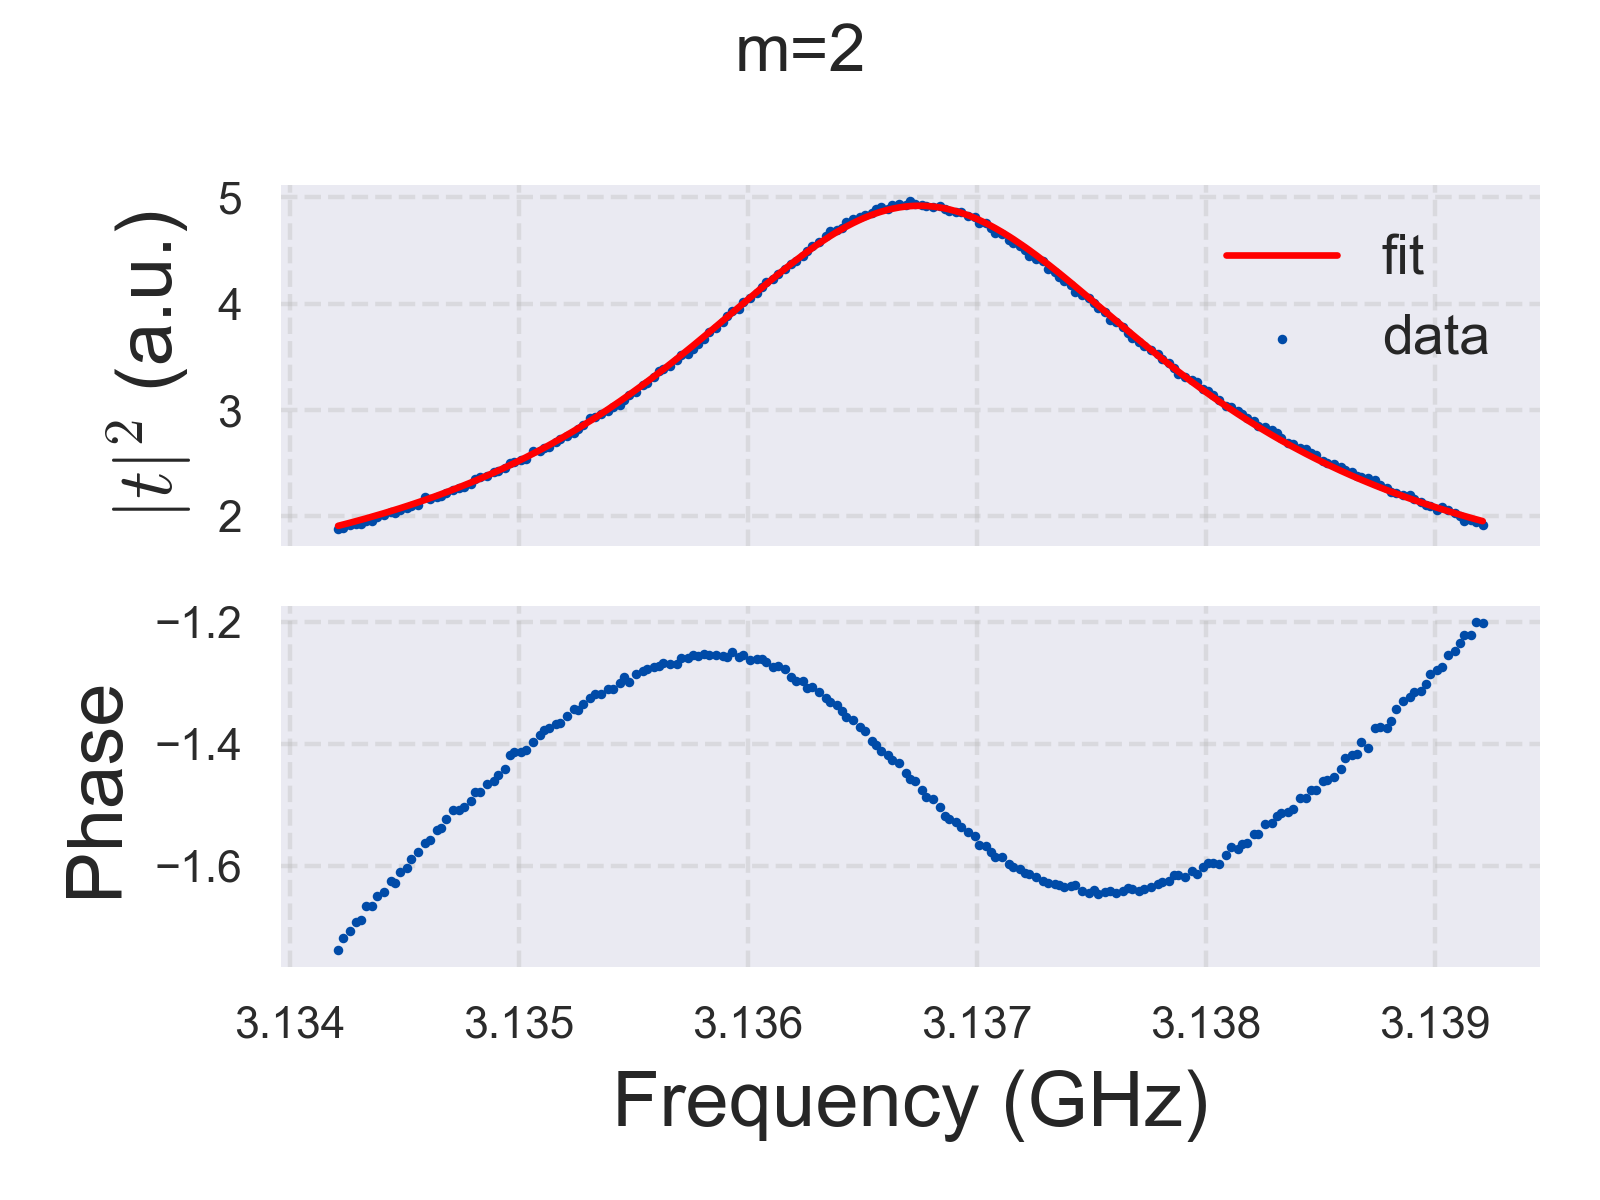

In [157]:
## Fitting resonator modes
## Raw data files: res01, cell Ay

FILENAME="./data/CQPS paper/data for article/TiN95_CQPS_C_July12'20_res_01.xlsx"

## Second resonator mode
# Load data
import pandas as pd
df = pd.read_excel (FILENAME, sheet_name='m2')
m2 = pd.DataFrame(df, columns=['Frequency','r','e'])
freq = df['Frequency']*10**-9 #in GHz
Mag = df['r'] #r
Phase = df['e'] #e

## Lorentzian fit to obtain loaded Quality factor, Q_l

import scipy as sp
from scipy.optimize import curve_fit 

def _S21(f,fr,Ql,A,c):
       return A**2/(1.+4.*Ql**2*((f-fr)/fr)**2)+c
# Initial guess of the parameters (you must find them some way!)
pguess = [3.1368, 1511, 9,1]
# Fit the data, does not work
popt, pcov = curve_fit(_S21, freq, Mag, p0 = pguess, method='lm')
# Results
print(popt)


# Plot data
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(4, 3))
fig.suptitle('m=2')
ax1.scatter(freq, Mag, marker="o", s=2, label='data')
#ax1.plot(freq, myfit(freq, pguess[0], pguess[1], pguess[2], pguess[3]),'g',label='intial guess') #plot initial guess
ax1.plot(freq,_S21(freq, popt[0], popt[1], popt[2], popt[3]),'r',label='fit') #plot fit
ax1.legend()
ax1.legend()
#ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylabel("$|t|^2 $ (a.u.)")
ax2.scatter(freq, Phase, marker="o", s=2)
ax2.set_xlabel("Frequency (GHz)")
ax2.set_ylabel("Phase")
plt.tight_layout()




[  5.12444942 827.09032137   1.97098239   1.08381528]


<IPython.core.display.Javascript object>


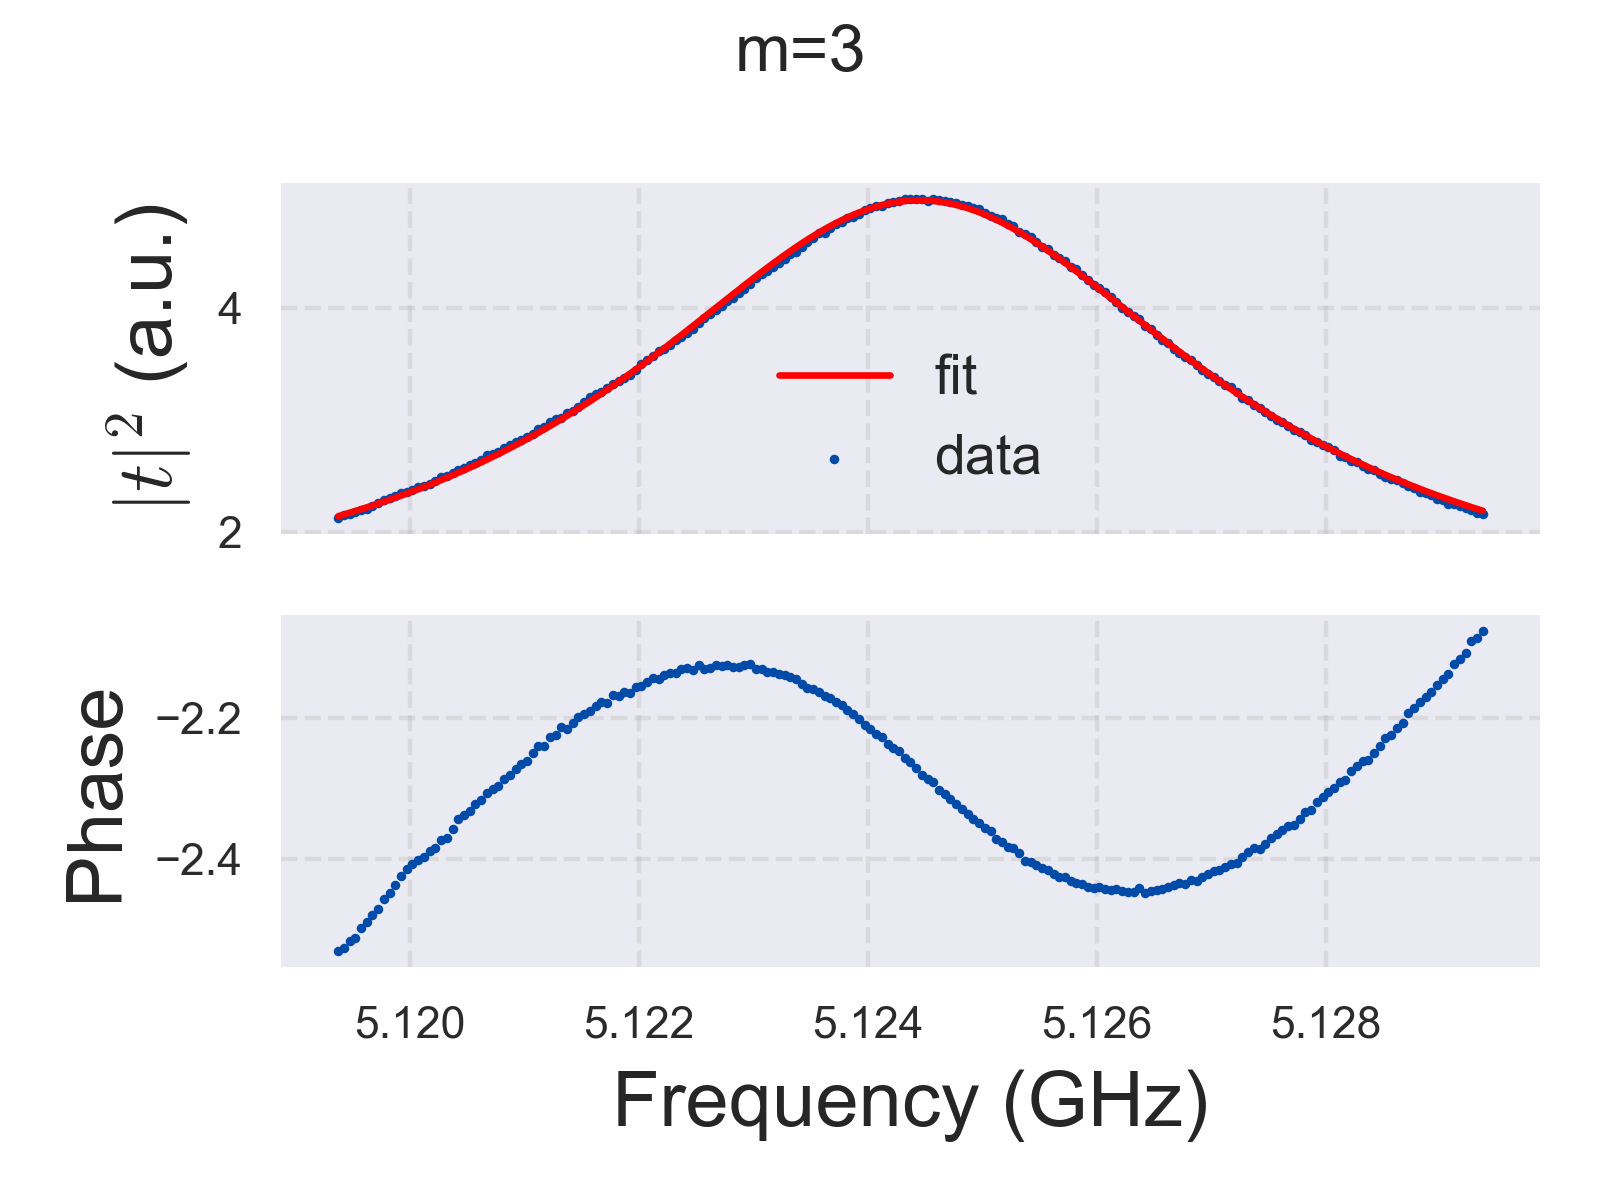

In [139]:
## Fitting resonator modes
## Raw data files: res01

FILENAME="./data/CQPS paper/data for article/TiN95_CQPS_C_July12'20_res_01.xlsx"

## Third resonator mode, m=3
# Load data
import pandas as pd
df = pd.read_excel (FILENAME, sheet_name='m3')
m3 = pd.DataFrame(df, columns=['Frequency','r','e'])
freq = df['Frequency']*10**-9 #in GHz
Mag = df['r'] #r
Phase = df['e'] #e

## Lorentzian fit to obtain loaded Quality factor, Q_l

import scipy as sp
from scipy.optimize import curve_fit 

def _S21(f,fr,Ql,A,c):
       return A**2/(1.+4.*Ql**2*((f-fr)/fr)**2)+c
# Initial guess of the parameters (you must find them some way!)
pguess = [5.124, 1129, 2,0]
# Fit the data, does not work
popt, pcov = curve_fit(_S21, freq, Mag, p0 = pguess, method='lm')
# Results
print(popt)


# Plot data
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(4, 3))
fig.suptitle('m=3')
ax1.scatter(freq, Mag, marker="o", s=2, label='data')
#ax1.plot(freq, _S21(freq, pguess[0], pguess[1], pguess[2], pguess[3]),'g',label='intial guess') #plot initial guess
ax1.plot(freq,_S21(freq, popt[0], popt[1], popt[2], popt[3]),'r',label='fit') #plot fit
ax1.legend()
ax1.legend()
#ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylabel("$|t|^2 $ (a.u.)")
ax2.scatter(freq, Phase, marker="o", s=2)
ax2.set_xlabel("Frequency (GHz)")
ax2.set_ylabel("Phase")
plt.tight_layout()

[  6.28351303 400.38436417   1.85494977  -0.48603808]


<IPython.core.display.Javascript object>


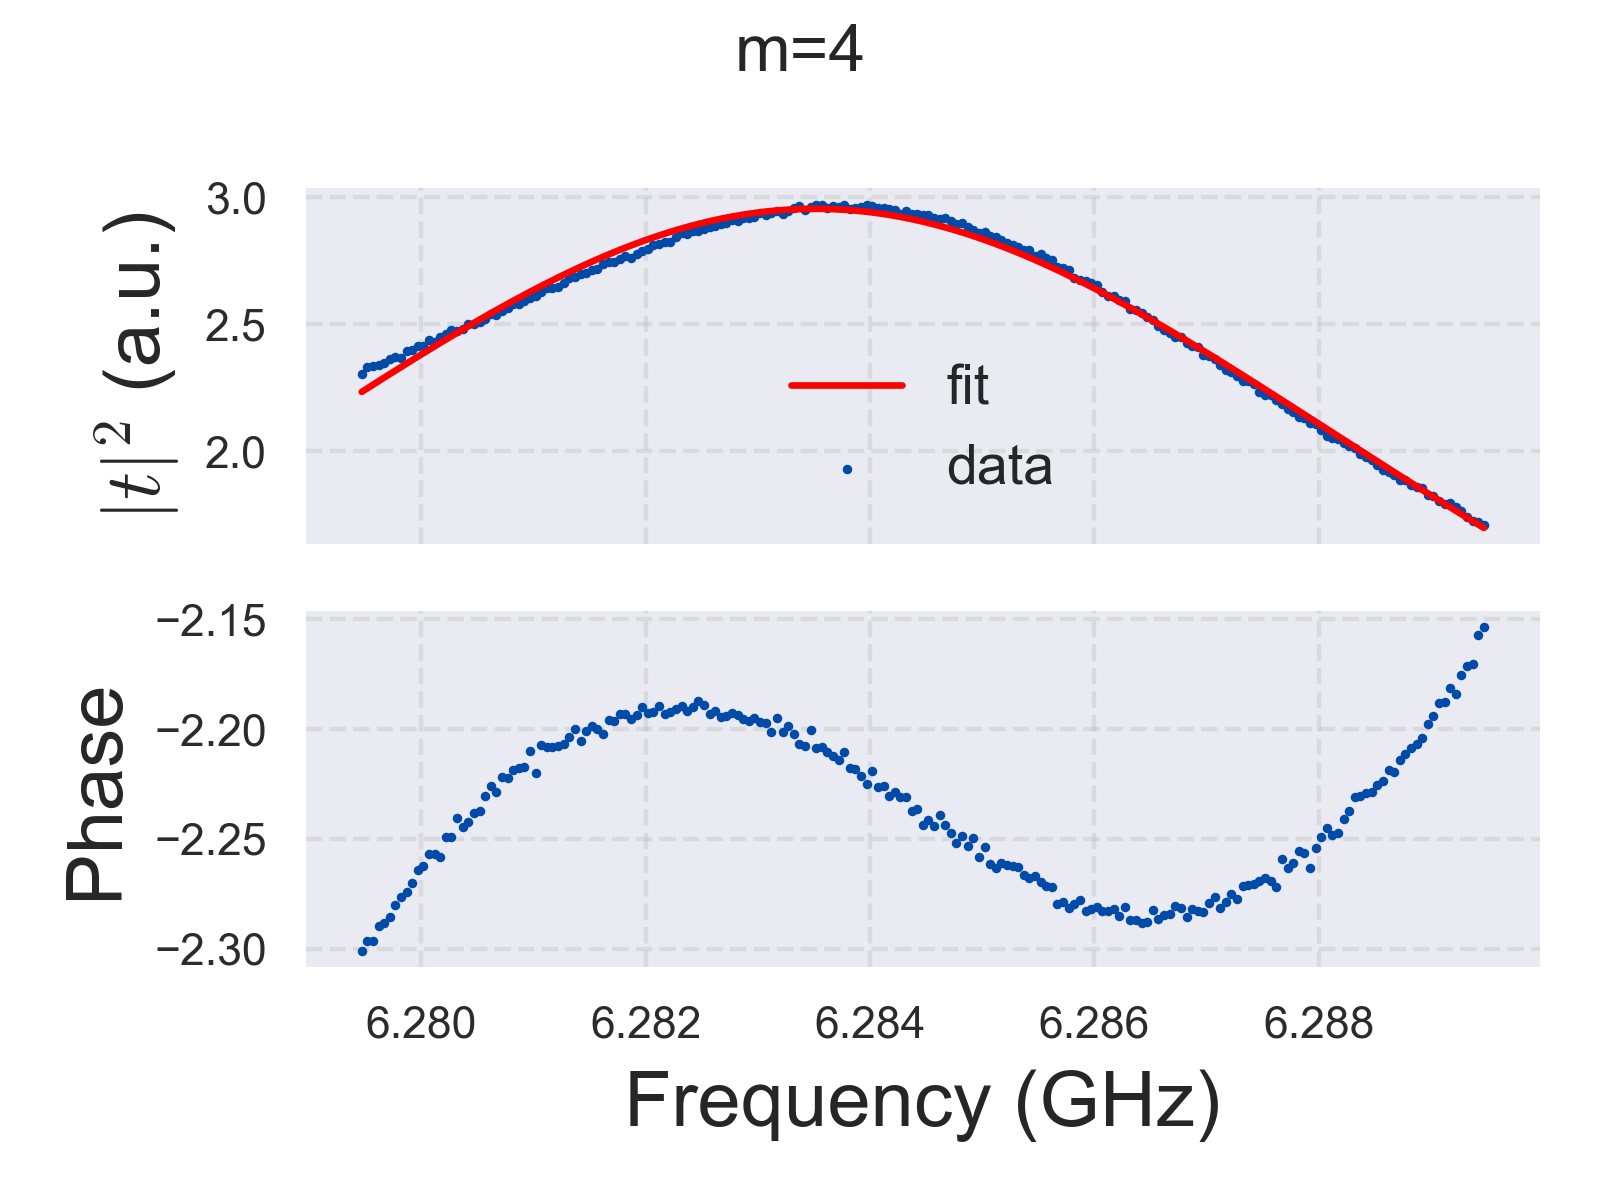

In [144]:
## Fitting resonator modes
## Raw data files: res01

FILENAME="./data/CQPS paper/data for article/TiN95_CQPS_C_July12'20_res_01.xlsx"

## Fourth resonator mode, m=4
# Load data
import pandas as pd
df = pd.read_excel (FILENAME, sheet_name='m4')
m4 = pd.DataFrame(df, columns=['Frequency','r','e'])
freq = df['Frequency']*10**-9 #in GHz
Mag = df['r'] #r
Phase = df['e'] #e

## Lorentzian fit to obtain loaded Quality factor, Q_l

import scipy as sp
from scipy.optimize import curve_fit 

def _S21(f,fr,Ql,A,c):
       return A**2/(1.+4.*Ql**2*((f-fr)/fr)**2)+c
# Initial guess of the parameters (you must find them some way!)
pguess = [6.284, 1129, 2,0]
# Fit the data, does not work
popt, pcov = curve_fit(_S21, freq, Mag, p0 = pguess, method='lm')
# Results
print(popt)


# Plot data
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(4, 3))
fig.suptitle('m=4')
ax1.scatter(freq, Mag, marker="o", s=2, label='data')
#ax1.plot(freq, _S21(freq, pguess[0], pguess[1], pguess[2], pguess[3]),'g',label='intial guess') #plot initial guess
ax1.plot(freq,_S21(freq, popt[0], popt[1], popt[2], popt[3]),'r',label='fit') #plot fit
ax1.legend()
ax1.legend()
#ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylabel("$|t|^2 $ (a.u.)")
ax2.scatter(freq, Phase, marker="o", s=2)
ax2.set_xlabel("Frequency (GHz)")
ax2.set_ylabel("Phase")
plt.tight_layout()

[7.94623325e+00 5.56754239e+02 1.00348052e+00 3.01763336e-01]


<IPython.core.display.Javascript object>


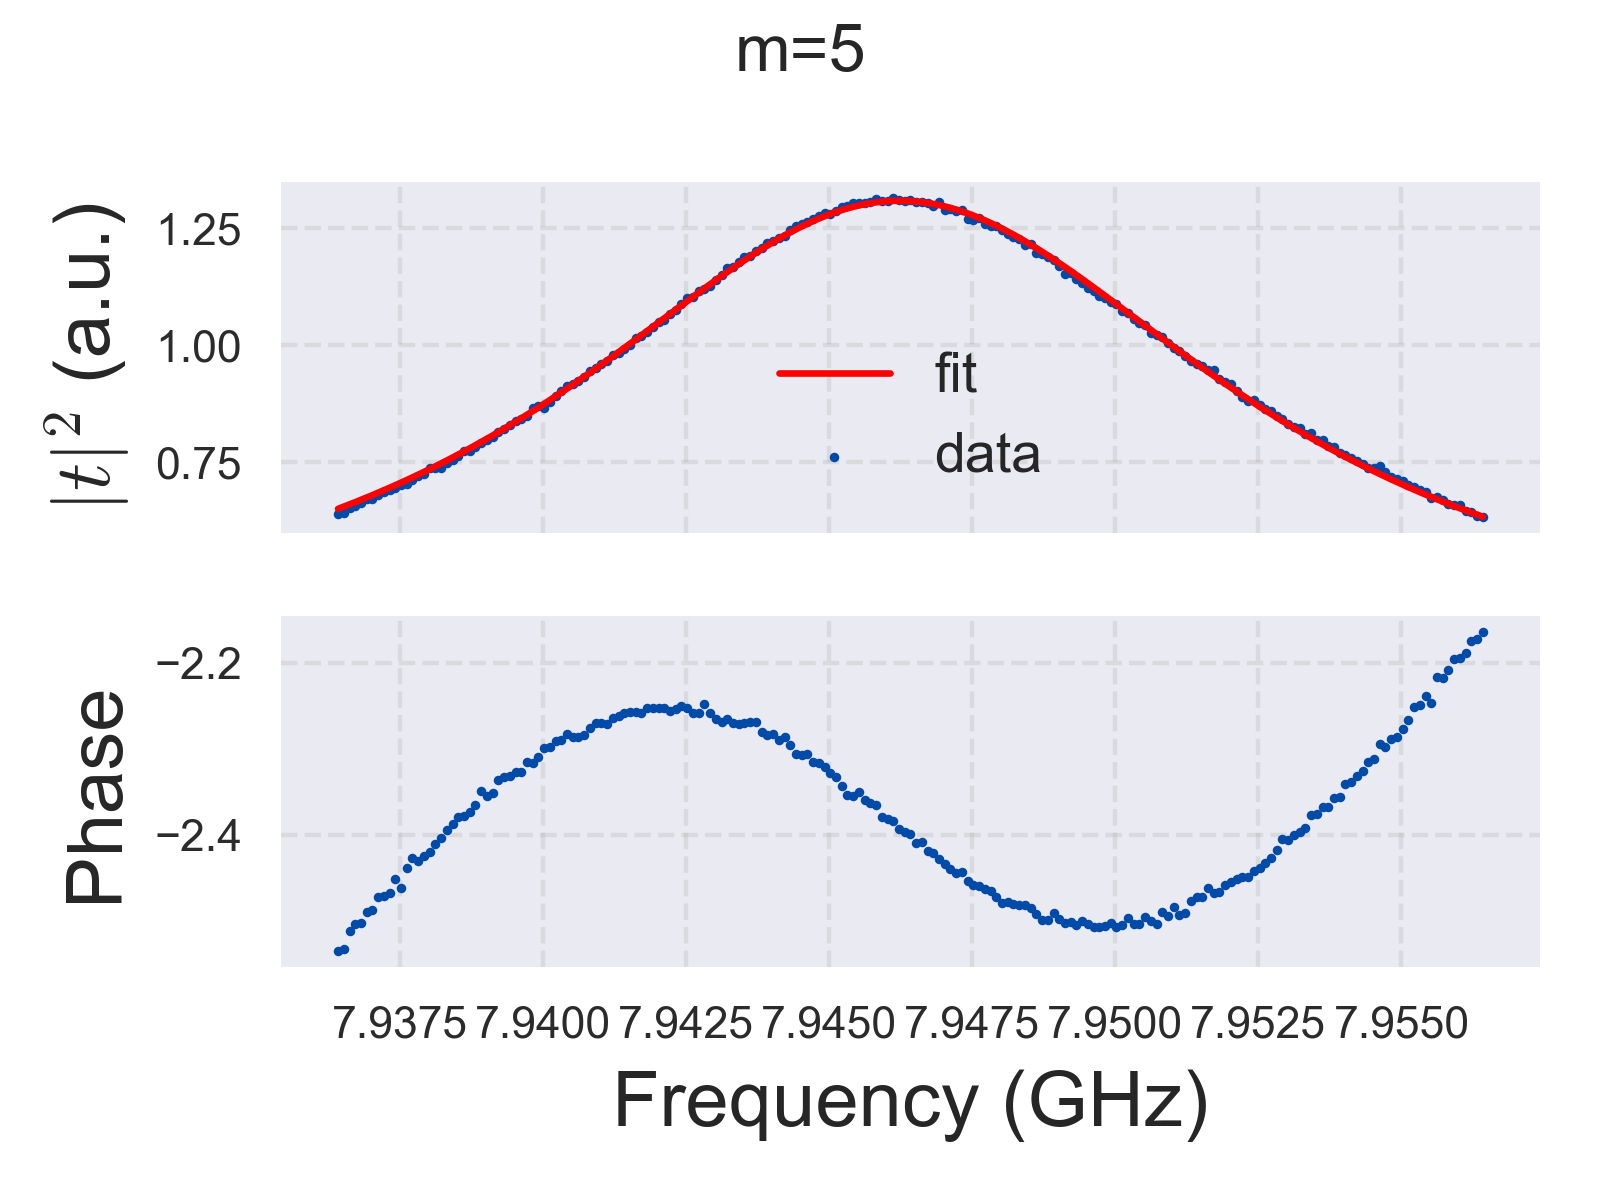

In [156]:
## Fitting resonator modes
## Raw data files: res01

FILENAME="./data/CQPS paper/data for article/TiN95_CQPS_C_July12'20_res_01.xlsx"

## Fifth resonator mode, m=5
# Load data
import pandas as pd
df = pd.read_excel (FILENAME, sheet_name='m5')
m5 = pd.DataFrame(df, columns=['Frequency','r','e'])
freq = df['Frequency']*10**-9 #in GHz
Mag = df['r'] #r
Phase = df['e'] #e

## Lorentzian fit to obtain loaded Quality factor, Q_l

import scipy as sp
from scipy.optimize import curve_fit 

def _S21(f,fr,Ql,A,c):
       return A**2/(1.+4.*Ql**2*((f-fr)/fr)**2)+c
# Initial guess of the parameters (you must find them some way!)
pguess = [7.95, 900, 2,0]
# Fit the data, does not work
popt, pcov = curve_fit(_S21, freq, Mag, p0 = pguess, method='lm')
# Results
print(popt)


# Plot data
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(4, 3))
fig.suptitle('m=5')
ax1.scatter(freq, Mag, marker="o", s=2, label='data')
#ax1.plot(freq, _S21(freq, pguess[0], pguess[1], pguess[2], pguess[3]),'g',label='intial guess') #plot initial guess
ax1.plot(freq,_S21(freq, popt[0], popt[1], popt[2], popt[3]),'r',label='fit') #plot fit
ax1.legend()
ax1.legend()
#ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylabel("$|t|^2 $ (a.u.)")
ax2.scatter(freq, Phase, marker="o", s=2)
ax2.set_xlabel("Frequency (GHz)")
ax2.set_ylabel("Phase")
plt.tight_layout()

[5.12091396e+00 6.40045433e+02 1.17267442e+00 1.42362431e-01]


<IPython.core.display.Javascript object>


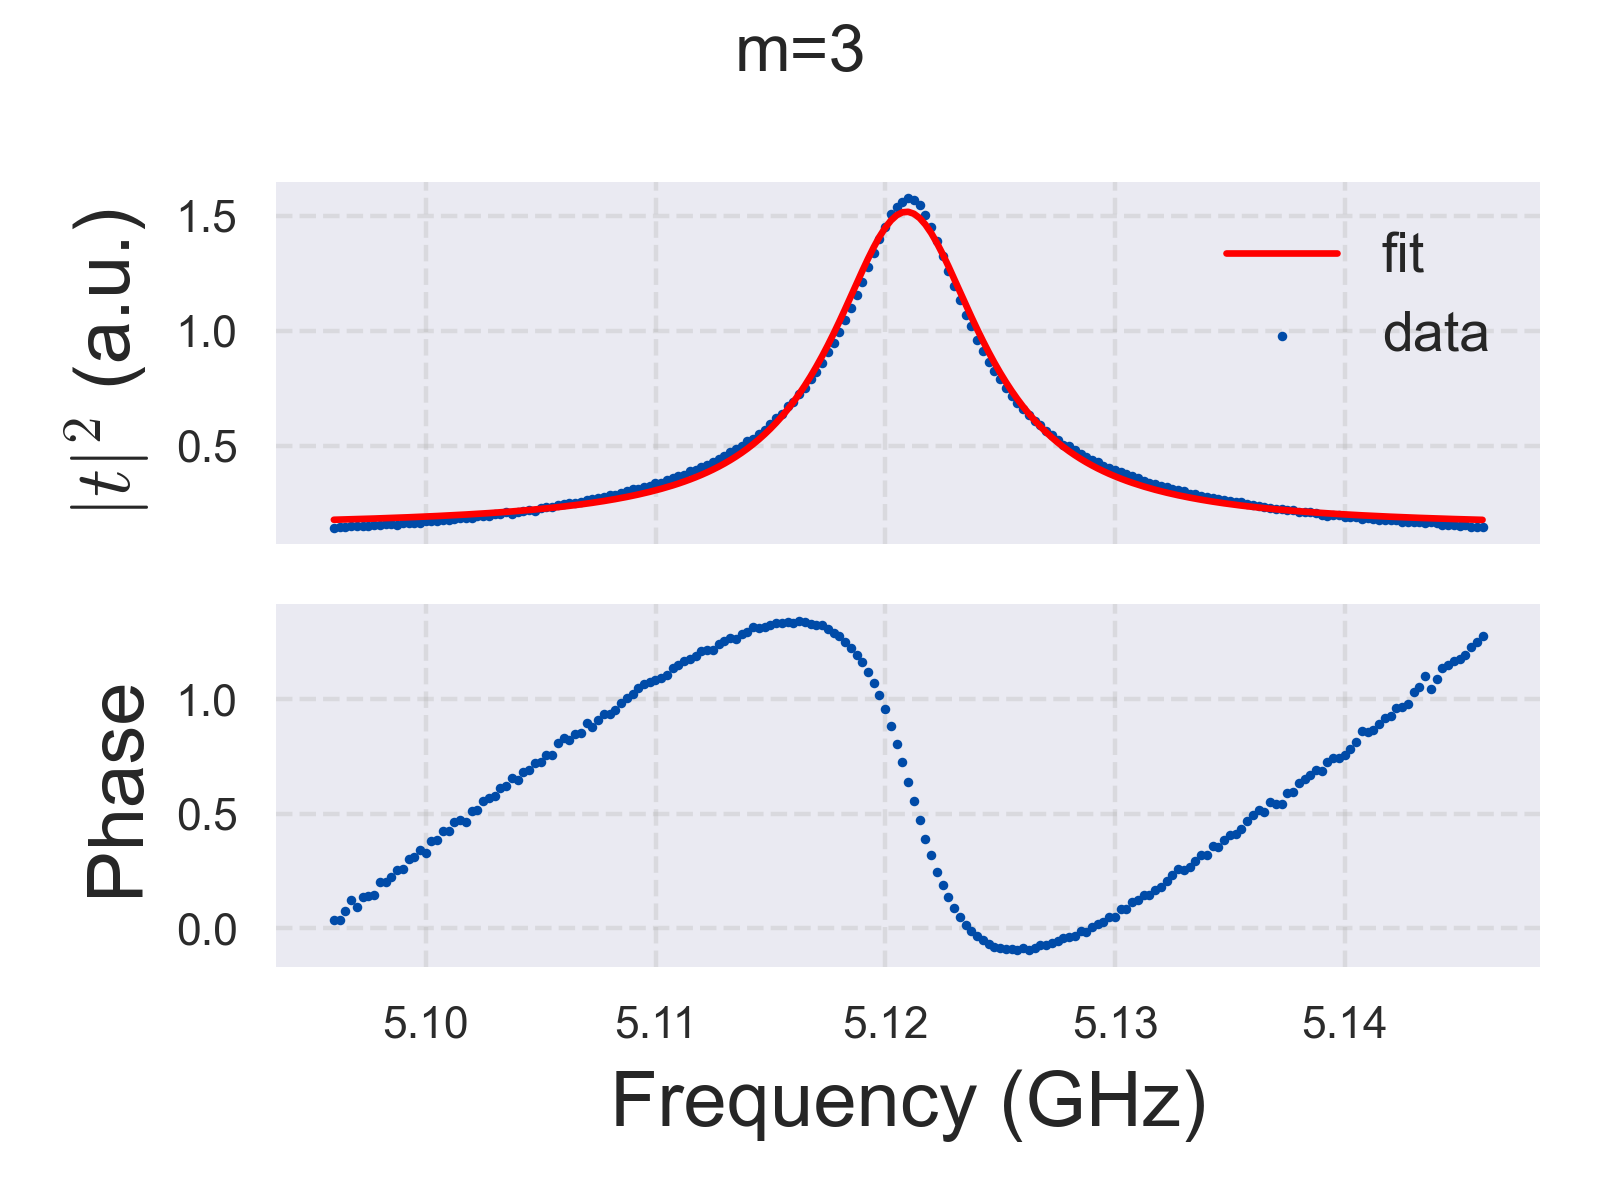

In [158]:
## Fitting resonator modes
## Raw data files: Ay cell, res01

FILENAME="./data/CQPS paper/data for article/TiN95_CQPS_C_July12'20_res_01.xlsx"

## Third resonator mode? but at higher power? Power used was -15dB
# Load data
import pandas as pd
df = pd.read_excel (FILENAME, sheet_name='m6')
m3 = pd.DataFrame(df, columns=['Frequency','r','e'])
freq = df['Frequency']*10**-9 #in GHz
Mag = df['r'] #r
Phase = df['e'] #e

## Lorentzian fit to obtain loaded Quality factor, Q_l

import scipy as sp
from scipy.optimize import curve_fit 

def _S21(f,fr,Ql,A,c):
       return A**2/(1.+4.*Ql**2*((f-fr)/fr)**2)+c
# Initial guess of the parameters (you must find them some way!)
pguess = [5.12444942, 827.09032137,   1.97098239,   0]
# Fit the data, does not work
popt, pcov = curve_fit(_S21, freq, Mag, p0 = pguess, method='lm')
# Results
print(popt)


# Plot data
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(4, 3))
fig.suptitle('m=3')
ax1.scatter(freq, Mag, marker="o", s=2, label='data')
#ax1.plot(freq, _S21(freq, pguess[0], pguess[1], pguess[2], pguess[3]),'g',label='intial guess') #plot initial guess
ax1.plot(freq,_S21(freq, popt[0], popt[1], popt[2], popt[3]),'r',label='fit') #plot fit
ax1.legend()
ax1.legend()
#ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylabel("$|t|^2 $ (a.u.)")
ax2.scatter(freq, Phase, marker="o", s=2)
ax2.set_xlabel("Frequency (GHz)")
ax2.set_ylabel("Phase")
plt.tight_layout()

# Fitting of qubit spectrum
First we evalaute the transition energies of the cqps system
\begin{equation}
\mathcal{H} = E_L(\hat{n} - f)^2 - \frac{E_s}{2}\bigg[\left|n+1\right\rangle{\left\langle{n}\right|} + \left|n\right\rangle{\left\langle{n+1}\right|}\bigg],
\end{equation}

(It is very similar to the transmon Hamiltonian)
\begin{equation}
    \mathcal{H} = E_C{\left(\hat{N}-N_\text{ext}\right)^2}- \frac{E_J}{2}\bigg(\left|n+1\right\rangle{\left\langle n\right|}+\left|n\right\rangle{\left\langle n+1\right|}\bigg)
\end{equation}
    
I will simply use the transmon Hamitlonian to evaluate energies

In [ ]:
Lsq = 2*10**(-9)
EL = 50

Nsq = Phi0**2 / (2 * Lsq * EL * h *GHz)
Ip = EL * h *GHz / Phi0 / nA
Ip, Nsq

In [ ]:
Lsq = 2*10**(-9)
EL = 40

Nsq = Phi0**2 / (2 * Lsq * EL * h *GHz)
Ip = EL * h *GHz / Phi0 / nA
Ip, Nsq

<IPython.core.display.Javascript object>


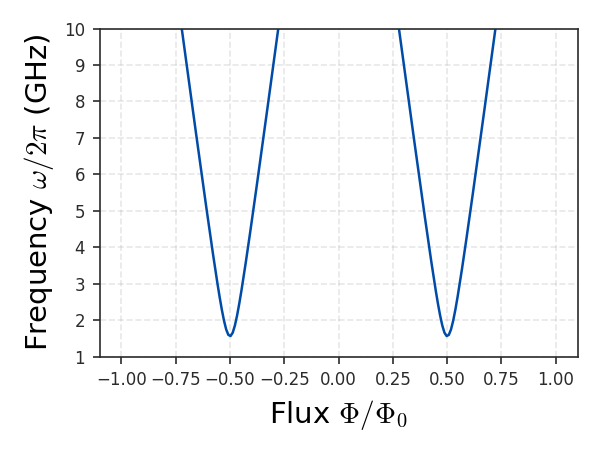

In [3]:
# Here we create the object with which we simulate cqps energies (very simple Hamiltonian). This is reused in all further cells
SIMULATION_PARAMETERS = {
    "number_of_states": 13,
    "number_of_levels_to_simulate": 2
}
QUBIT_PARAMETERS = {
    # We will override them in subsequent evaluations
    "ES": 10,
    "inductive_loop_squares": 30, # 30 140x140nm squares
     **SIMULATION_PARAMETERS
}
cqps_qubit = QuantumBuilder.build_cqps_qubit(
    QUBIT_PARAMETERS, logging_level=logging.ERROR,
)

# Example invocation
FLUX_NUMBER = np.linspace(0, 1, 200)
EL_list = [10, 20, 40, 80]
ES = 2
f01_list = []

for EL in EL_list:
    cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
    simulation = cqps_qubit.run_simulation(
        FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
    qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]
    f01_list.append(qubit_f01)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.axhspan(2, 20, color='red', alpha=0.1)

for i, qubit_f01 in enumerate(f01_list):
    Ip = EL_list[i] * h *GHz / Phi0 / nA
    simulation_graph, = ax.plot(FLUX_NUMBER, qubit_f01, 
#                                 label=f"{Ip:.2f} nA"
                                    label=f"{EL_list[i]} GHz"
                               )

ax.legend(title="$E_L$")
ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([0,25])
plt.tight_layout()

# plt.savefig("./output/cqps-single-simulation-1.pdf")
plt.savefig("./output/cqps-single-simulation-2.pdf")

# Next we inroduce interaction with the resonator
*Hamitlonian at this stage*

\begin{equation}
 \frac{1}{\hbar}H_{qubit-resonator} = \frac{\omega_{q}}{2}\sigma_z + \omega_r{a^{\dagger}}a + g(a^{\dagger} + a)\sigma_x
\end{equation}

In the truncated matrix form between states $\left|e, N\right\rangle$ and $\left|g, N+1\right\rangle$
\begin{equation}
  \mathcal{H}_{middle} = \begin{pmatrix}
    \frac{\omega_q}{2} + (N)\omega_r & g\sqrt{N+1}\\
    g\sqrt{N+1} & -\frac{\omega_q}{2} + (N+1)\omega_r
  \end{pmatrix}
\end{equation}

We introduce the detuning factor $\delta =\omega_{q} - \omega_{r}$ in order to write out

\begin{equation}
  \mathcal{H}_{middle} = \begin{pmatrix}
    \frac{\delta}{2} + (N+\frac{1}{2})\omega_r & g\sqrt{N+1}\\
    g\sqrt{N+1} & -\frac{\delta}{2} + (N+\frac{1}{2})\omega_r
  \end{pmatrix}
\end{equation}

which reads as
\begin{equation}
  \begin{aligned}
      &= {\hbar\omega_r(N+\frac{1}{2})\mathbb{I} +\frac{ \hbar\delta}{2}\sigma_z} + {\hbar g_0\sqrt{N+1}\sigma_x}\\
      & = {\hbar\omega_r(N+\frac{1}{2})\mathbb{I}} + \frac{1}{2}\sqrt{(\hbar\delta)^2 + 4\hbar^2g_0^2(N+1)} \bigg(\cos(\theta)\sigma_z + \sin(\theta)\sigma_x\bigg)\\
      & = \hbar\omega_r(N+\frac{1}{2})\mathbb{I} + E_{\text{coupled}}(\cos(\theta)\sigma_z + \sin(\theta)\sigma_x)\\
      & \text{where } E_\text{coupled} = \frac{\hbar}{2}\sqrt{\delta^2 + 4g_0^2(N+1)};\qquad \tan(\theta) = \frac{g_0\sqrt{N+1}}{\delta/2}.
  \end{aligned}
\end{equation}

and thus, like in the paper after doing the torating frame

\begin{equation}
\frac{E}{\hbar} = \left( n + \frac{1}{2} \right)\omega_{r} + \frac{\omega_q}{2} \pm \sqrt{\left( \frac{\delta}{2} \right)^2 + g_0^2(N+1)}
\end{equation}

At `N = 0`

\begin{equation}
 \frac{E}{\hbar} = \frac{\omega_{r}}{2} + \frac{\omega_{q}}{2} \pm \sqrt{\left( \frac{\delta}{2} \right)^{2} + g^2}
\end{equation}

**All in units of radians. Therefore any measurement on the VNA is actually $X/2\pi$**

*e.g. we are fitting $g/2\pi$ to the experimental results*

0


<IPython.core.display.Javascript object>


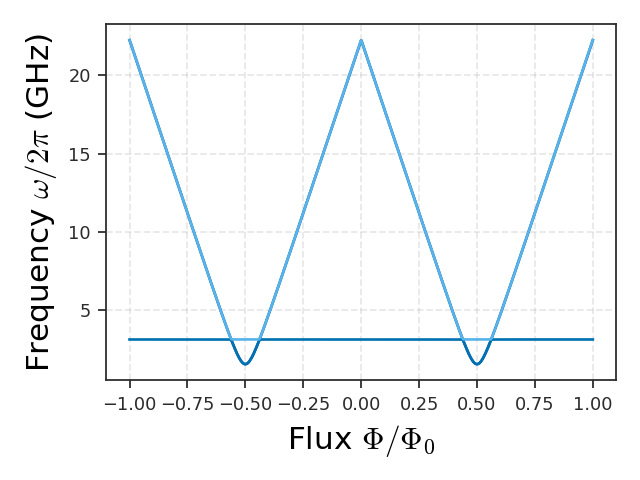

In [72]:
def qubit_resonator_spectrum(qubit_f01: list, resonator_f: float, g: float, N:int=0):
    "See equation (6) above"
    e_high = []
    e_low = []
    print(N)
    for dQubit in qubit_f01:
        a = dQubit / 2
        b = resonator_f * (N + 1/2)
        c = (dQubit - resonator_f) / 2

        factor = np.sqrt(c**2 + g**2*(N+1))
        e_high.append(a+b+factor)
        e_low.append(a+b-factor)
        
    return (e_low, e_high)

# Example invocation
g = 29.9 * (MHz/GHz) # Everything is done in GHz, but MHz is the natural scale
resonator_f = 3.13461
(e_low, e_high) = qubit_resonator_spectrum(qubit_f01, resonator_f, g, N=0)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
qubit_graph, = ax.plot(FLUX_NUMBER, qubit_f01)
e_low_plot, = ax.plot(FLUX_NUMBER, e_low)
e_high_plot, = ax.plot(FLUX_NUMBER, e_high)

ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
# ax.set_ylim([3.1,3.2])
plt.tight_layout()

# Master equations simulation

We are solving the master equation for the full system

 \begin{equation}
  \begin{aligned}
    \dot{\rho} = -\frac{i}{\hbar}\left[ \mathcal{H}, \rho \right] + \mathcal{L}\left[ \rho \right] & = i\frac{\delta_{q}}{2}\left[ \sigma_z\rho - \rho\sigma_z \right] -i\delta_{r}\left[ {a}^{\dagger}a\rho - \rho{a}^{\dagger}a \right]\\
    & - ig{\left[ a\sigma_+\rho - \rho{a}\sigma_+ + {a}^{\dagger}\sigma_{-}\rho - \rho{a}^{\dagger}\sigma_{-} \right]}\\
    & - i{\frac{\Omega}{2}}\left[ a\rho - \rho{a} + {a}^{\dagger}\rho - \rho{a}^{\dagger} \right]\\
    & + \frac{\kappa}{2}\left[ 2a\rho{a}^{\dagger} - {a}^{\dagger}a\rho - \rho{a}^{\dagger}a \right]\\
    & + \frac{\Gamma_{1}}{2}\left[ 2\sigma_{-}\rho\sigma_{+} - \sigma_+\sigma_{-}\rho - \rho\sigma_+\sigma_{-} \right]\\
    & + \frac{\Gamma_{\phi}}{2}\left[ \sigma_z\rho\sigma_z - \rho \right]
  \end{aligned}
 \end{equation}


## Representation in 2 qubit - 2 resonator basis (N=0, N=1)

We will use the truncated subspace of vectors in the following $\left|e, n\right\rangle, \left|e, n+1\right\rangle, \left|g, n\right\rangle, \left|g, n+1\right\rangle$ with $n=0$

The representation of operator $\hat{A}$ in this subspace will be
\begin{equation}
 \begin{pmatrix}
   \left\langle e, n\right|\hat{A}{\left|e, n\right\rangle} & \left\langle e, n+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle e, n\right|\hat{A}{\left|g, n\right\rangle} & \left\langle e, n\right|\hat{A}{\left|g, n+1\right\rangle}\\
   \left\langle e, n+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle e, n+1+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle e, n+1\right|\hat{A}{\left|g, n\right\rangle} & \left\langle e, n+1\right|\hat{A}{\left|g, n+1\right\rangle}\\
   \left\langle g, n\right|\hat{A}{\left|e, n\right\rangle} & \left\langle g, n+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle g, n\right|\hat{A}{\left|g, n\right\rangle} & \left\langle g, n\right|\hat{A}{\left|g, n+1\right\rangle}\\
   \left\langle g, n+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle g, n+1+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle g, n+1\right|\hat{A}{\left|g, n\right\rangle} & \left\langle g, n+1\right|\hat{A}{\left|g, n+1\right\rangle}\\
 \end{pmatrix}
\end{equation}

In [4]:
NR = 2
OFFSET = 0

qubit_ket = qt.basis(2,0)
resonator_ket = qt.basis(NR, 0)
example_state = qt.tensor(
    [
        qt.ket2dm(qubit_ket), 
        qt.ket2dm(resonator_ket)
    ])
example_state

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

\begin{equation}
  \sigma_z =
  \begin{pmatrix}
    1 & . & . & . \\
    . & 1 & . & . \\
    . & . & -1 & .\\
    . & . & . & -1
  \end{pmatrix}
\end{equation}

In [5]:
op_sigmaz = qt.tensor(
    qt.sigmaz(),
    qt.identity(NR)
)
op_sigmaz

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0. -1.]]

\begin{equation}
  a=
  \begin{pmatrix}
    . & \sqrt{n+1} & . & . \\
    . & .& .& .\\
    . & . & . & \sqrt{n+1} \\
    . & . & . & .
  \end{pmatrix}
\end{equation}

In [6]:
op_a = qt.tensor(
    qt.identity(2),
    qt.destroy(NR, offset=OFFSET)
)
op_a

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]

\begin{equation}
  a^{\dagger}=
  \begin{pmatrix}
    . & . & . & . \\
    \sqrt{n} & .& .& .\\
    . & . & . & . \\
    . & . & \sqrt{n} & .
  \end{pmatrix}
\end{equation}


In [7]:
op_adagger = qt.tensor(
    qt.identity(2),
    qt.create(NR, offset=OFFSET)
)
op_adagger

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]]

\begin{equation}
  \sigma_{-} =
  \begin{pmatrix}
    . & . & . & . \\
    . & . & . & . \\
    1 & . & . & . \\
    . & 1 & . & .
  \end{pmatrix}
\end{equation}

In [8]:
op_sigmaminus = qt.tensor(
    qt.sigmam(),
    qt.identity(NR)
)
op_sigmaminus

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]

\begin{equation}
  \sigma_{+} =
  \begin{pmatrix}
    . & . & 1 & . \\
    . & . & . & 1 \\
    . & . & . & . \\
    . & . & . & .
  \end{pmatrix}
\end{equation}

In [9]:
op_sigmaplus = qt.tensor(
    qt.sigmap(),
    qt.identity(NR)
)
op_sigmaplus

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

\begin{equation}
  a^{\dagger}a =
  \begin{pmatrix}
    n & . & . & . \\
    . & n+1 & . & . \\
    . & . & n & . \\
    . & . & . & n+1
  \end{pmatrix}
\end{equation}

In [10]:
op_n = qt.tensor(
    qt.identity(2),
    qt.num(NR, offset=OFFSET)
)
op_n

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]]

\begin{equation}
  a\sigma_{+}=
  \begin{pmatrix}
    . & . & . & \sqrt{n+1} \\
    . & . & . & . \\
    . & . & . & . \\
    . & . & . & .
  \end{pmatrix}
\end{equation}


In [11]:
op_a_sigmaplus = qt.tensor(
    qt.sigmap(),
    qt.destroy(NR, offset=OFFSET)
)
op_a_sigmaplus

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

\begin{equation}
  a^{\dagger}\sigma_-=
  \begin{pmatrix}
    . & . & . & . \\
    . & . & . & . \\
    . & . & . & . \\
    \sqrt{n+1} & . & . & .
  \end{pmatrix}
\end{equation}

In [12]:
op_adagger_sigmaminus = qt.tensor(
    qt.sigmam(),
    qt.create(NR, offset=OFFSET)
)
op_adagger_sigmaminus

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]]

## Analytical solution from mathematica
- Using **very** inefficient methods (manual substitution, since Mathematica chockes when told to solve for the 4x4 equations), we have found an analytical solution in the case of weak drive
- $\Omega << 1$ and therefore $\mathcal{O(\Omega^2)}$  terms were set to 0

- The expectation values:

\begin{equation}
  \begin{aligned}
 \left\langle a \right\rangle & = -i{\frac{\Omega/2}{\frac{g^{2}}{\frac{\Gamma_{1}}{2}+\Gamma_{\phi}+i\delta_q} + \left( \frac{\kappa}{2}+i\delta_r \right)}}\\
    &={\frac{\Omega/2}{\frac{g^{2}}{\delta_{q}-i{\left( \frac{\Gamma_{1}}{2}+\Gamma_{\phi} \right)}} - (\delta_r - i\frac{\kappa}{2})}}\\
  \end{aligned}
\end{equation}
\begin{equation}
  \begin{aligned}
     \left\langle a^\dagger \right\rangle &= i{\frac{\Omega/2}{\frac{g^{2}}{\frac{\Gamma_{1}}{2}+\Gamma_{\phi}-i\delta_q} + \left( \frac{\kappa}{2}-i\delta_r \right)}}\\
     &={\frac{\Omega/2}{\frac{g^{2}}{\delta_{q}+i{\left( \frac{\Gamma_{1}}{2}+\Gamma_{\phi} \right)}} - (\delta_r + i\frac{\kappa}{2})}}\\
  \end{aligned}
\end{equation}

- Solutions give the field in the resonator at the output line  and thus the voltage in the resonator
\begin{equation}
 V_r{\left( \left\langle a \right\rangle + \left\langle a^{\dagger} \right\rangle  \right)}
\end{equation}
This field induces a displacement current across capacitance $C_k$ through which the resonator couples to the output line $V_{resonator}/Z_{gap} = V_{resonator} / \frac{1}{i\omega{C_k}}$ which generates a voltage output line with impedance Z
\begin{equation}
 V_{out}(t) \approx V_r{\left( \left\langle a^{\dagger} \right\rangle + \left\langle a \right\rangle  \right)} \left[ -i\omega{C_{k}} \right]Z
\end{equation}

- Subbing in the values will give
\begin{equation}
\begin{aligned}
V_{out}(t) & = -i\omega{C_{k}}Z V_r \left[\frac{\Omega/2}{g^2/\delta_q' - \delta_r'}+cc\right]\\
& = -i\omega{C_{k}}Z V_r \frac{\Omega}{2}\left[ \frac{1}{g^2/\delta_q' - \delta_r'}+ cc\right]\\
 & = -i\omega{C_{k}}Z V_r \left[\frac{C_{k}V_{in}V_r}{\hbar}\frac{1}{2}\right]\left[ \frac{1}{g^2/\delta_q' - \delta_r'}+ cc\right]\\
 & = -i\omega{C_k^2Z}V_{in} \left[ \frac{1}{\hbar}\frac{1}{2} \right] \frac{\hbar\omega}{C_{r}}\left[ \frac{1}{g^2/\delta_q' - \delta_r'}+ cc\right]\\
 & = -i\frac{1}{2}V_{in}\frac{C_k^2\omega^2Z}{C_{r}}\left[ \frac{1}{g^2/\delta_q' - \delta_r'}+ cc\right]\\
\end{aligned}
\end{equation}

where:
- $\delta_{q}'=\delta_{q} + i\left( \frac{\Gamma_1}{2}+\Gamma_{\phi} \right)$
- $\delta_{r}'=\delta_{r} +i\frac{\kappa}{2}$

Then a simple ratio gives the transmission coefficient:
\begin{equation}
 t = \frac{V_{out}}{V_{in}} = -i\frac{1}{2}\frac{C_k^2\omega^2Z}{C_{r}}\left[ \frac{1}{g^2/\delta_q' - \delta_r'} + cc\right]
\end{equation}

which can be expanded in mathematica (bracket section)
\begin{equation}
\frac{2 g^2 \delta _q-2 \delta _q^2 \delta _r-2 \Gamma ^2 \delta _r}{\left(\Gamma  \kappa '+g^2\right)^2-2 g^2 \delta _q \delta _r+\delta _q^2 \left(\left(\kappa '\right)^2+\delta _r^2\right)+\Gamma ^2 \delta _r^2}
\end{equation}

<ipython-input-69-206b3149fad7>:23: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(


<IPython.core.display.Javascript object>


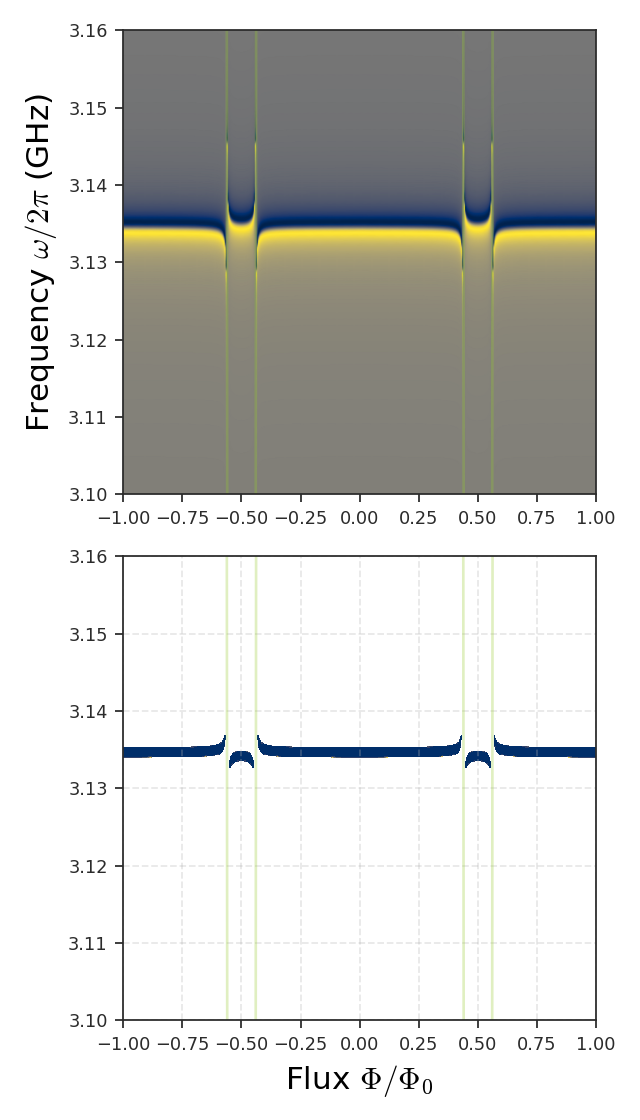

<ipython-input-69-206b3149fad7>:103: UserWarning: The following kwargs were not used by contour: 'sharex'
  ax.contourf(deltaXMesh, deltaYMesh, np.transpose(tGridNoCC), cmap=plt.cm.cividis,sharex=ax_arr[0])


In [69]:
def make_transmission_function_no_cc(Gamma1: float, GammaPhi:float, kappa: float, g: float):
    """
    Function defined within a function, so that it has seeded parameters for constant parameters
    
    See mathematica notebook for how this expansion was found.
    
    Make sure everything is in MHz (or everything is in GHz)
    """
    Gamma = Gamma1/2 + GammaPhi
    kappaPrime = kappa / 2
    twoGSquared = 2*g**2
    twoGammaSquared = 2*Gamma**2
    GammaSquared=Gamma**2
    gSquaredPlusGammaKappaPrimed_allSquared = (g**2 + Gamma*kappaPrime)**2
    kappaPrimeSquared = kappaPrime**2
    
    def transmission(delta_q: float, delta_r: float) -> float:
        delta_qSquared = delta_q**2
        delta_rSquared = delta_r**2
        return (
            1
            / 
            np.sqrt(
                ((g**2 * Gamma)/(GammaSquared+delta_qSquared)+kappaPrime)**2
                -
                ((g**2 * delta_q)/(GammaSquared+delta_qSquared) + delta_r)**2        
            )
        )
    return transmission

def make_transmission_function(Gamma1: float, GammaPhi:float, kappa: float, g: float):
    """
    Function defined within a function, so that it has seeded parameters for constant parameters
    
    See mathematica notebook for how this expansion was found.
    
    Make sure everything is in MHz (or everything is in GHz)
    """
    Gamma = Gamma1/2 + GammaPhi
    kappaPrime = kappa / 2
    twoGSquared = 2*g**2
    twoGammaSquared = 2*Gamma**2
    GammaSquared=Gamma**2
    gSquaredPlusGammaKappaPrimed_allSquared = (g**2 + Gamma*kappaPrime)**2
    kappaPrimeSquared = kappaPrime**2
    
    def transmission(delta_q: float, delta_r: float) -> float:
        delta_qSquared = delta_q**2
        delta_rSquared = delta_r**2
        return (
            (twoGSquared*delta_q - twoGammaSquared*delta_r - 2*delta_qSquared*delta_r)
            / 
            (- twoGSquared*delta_q*delta_r 
             + GammaSquared*delta_rSquared 
             + gSquaredPlusGammaKappaPrimed_allSquared 
             + delta_qSquared*(delta_rSquared + kappaPrimeSquared))
        )
    return transmission

# Example application
Gamma1 = 0.26 # Will be fitted
GammaPhi = 0
kappa = 1.39 # Taken from paper
g = 25
resonator_f = 3.13461
sweep_f = np.linspace(3.1, 3.16, 501)

# Simulate qubit
FLUX_NUMBER = np.linspace(-1, 1, 501)
EL = 22.2
ES = 1.56
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

# Construct a matrix of detunings. We step along the magnetic field (changing the freqyency of the qubit) and 
deltaQ = []
deltaR = []
for fq in qubit_f01:
    deltaQ.append(sweep_f - fq)
    deltaR.append(sweep_f - resonator_f)
deltaQ = np.array(deltaQ)*1000 #to convert from GHz to MHz
deltaR = np.array(deltaR)*1000

# Simulate qubit-resonator
tGrid = make_transmission_function(Gamma1, GammaPhi, kappa, g)(deltaQ, deltaR)
tGridNoCC = make_transmission_function_no_cc(Gamma1, GammaPhi, kappa, g)(deltaQ, deltaR)
deltaXMesh, deltaYMesh = np.meshgrid(FLUX_NUMBER, sweep_f)

# Plot
fig, ax_arr = plt.subplots(2, 1, figsize=(4, 7))
ax = ax_arr[0]
ax.pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tGrid), 
              shading='gouraud', 
            cmap=plt.cm.cividis);
ax.plot(FLUX_NUMBER, qubit_f01, color=MY_COLOURS["Green"], alpha=0.3)

ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([sweep_f[0], sweep_f[-1]])

ax = ax_arr[1]
ax.contourf(deltaXMesh, deltaYMesh, np.transpose(tGridNoCC), cmap=plt.cm.cividis,sharex=ax_arr[0])
ax.plot(FLUX_NUMBER, qubit_f01, color=MY_COLOURS["Green"], alpha=0.3)
ax.set_ylim([sweep_f[0], sweep_f[-1]])
ax.set_xlabel("Flux $\Phi/\Phi_0$")
plt.tight_layout()

# Multi Photon Process
- Tt cell

In [282]:
PERIOD = (1.084 - 0.485) / 3
FILENAME="./data/2020-07_cqps-single/multi-photon/TiN95_CQPS_C_July24'20_Tt_two_tone_03_data.txt"
OFFSET = 5.423 - 5.5

# Load 3d data
with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = (data3d_x) / PERIOD - OFFSET
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])
    
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)
FLUX_NUMBER = np.linspace(data3d_x[0], data3d_x[-1], 200)

<IPython.core.display.Javascript object>


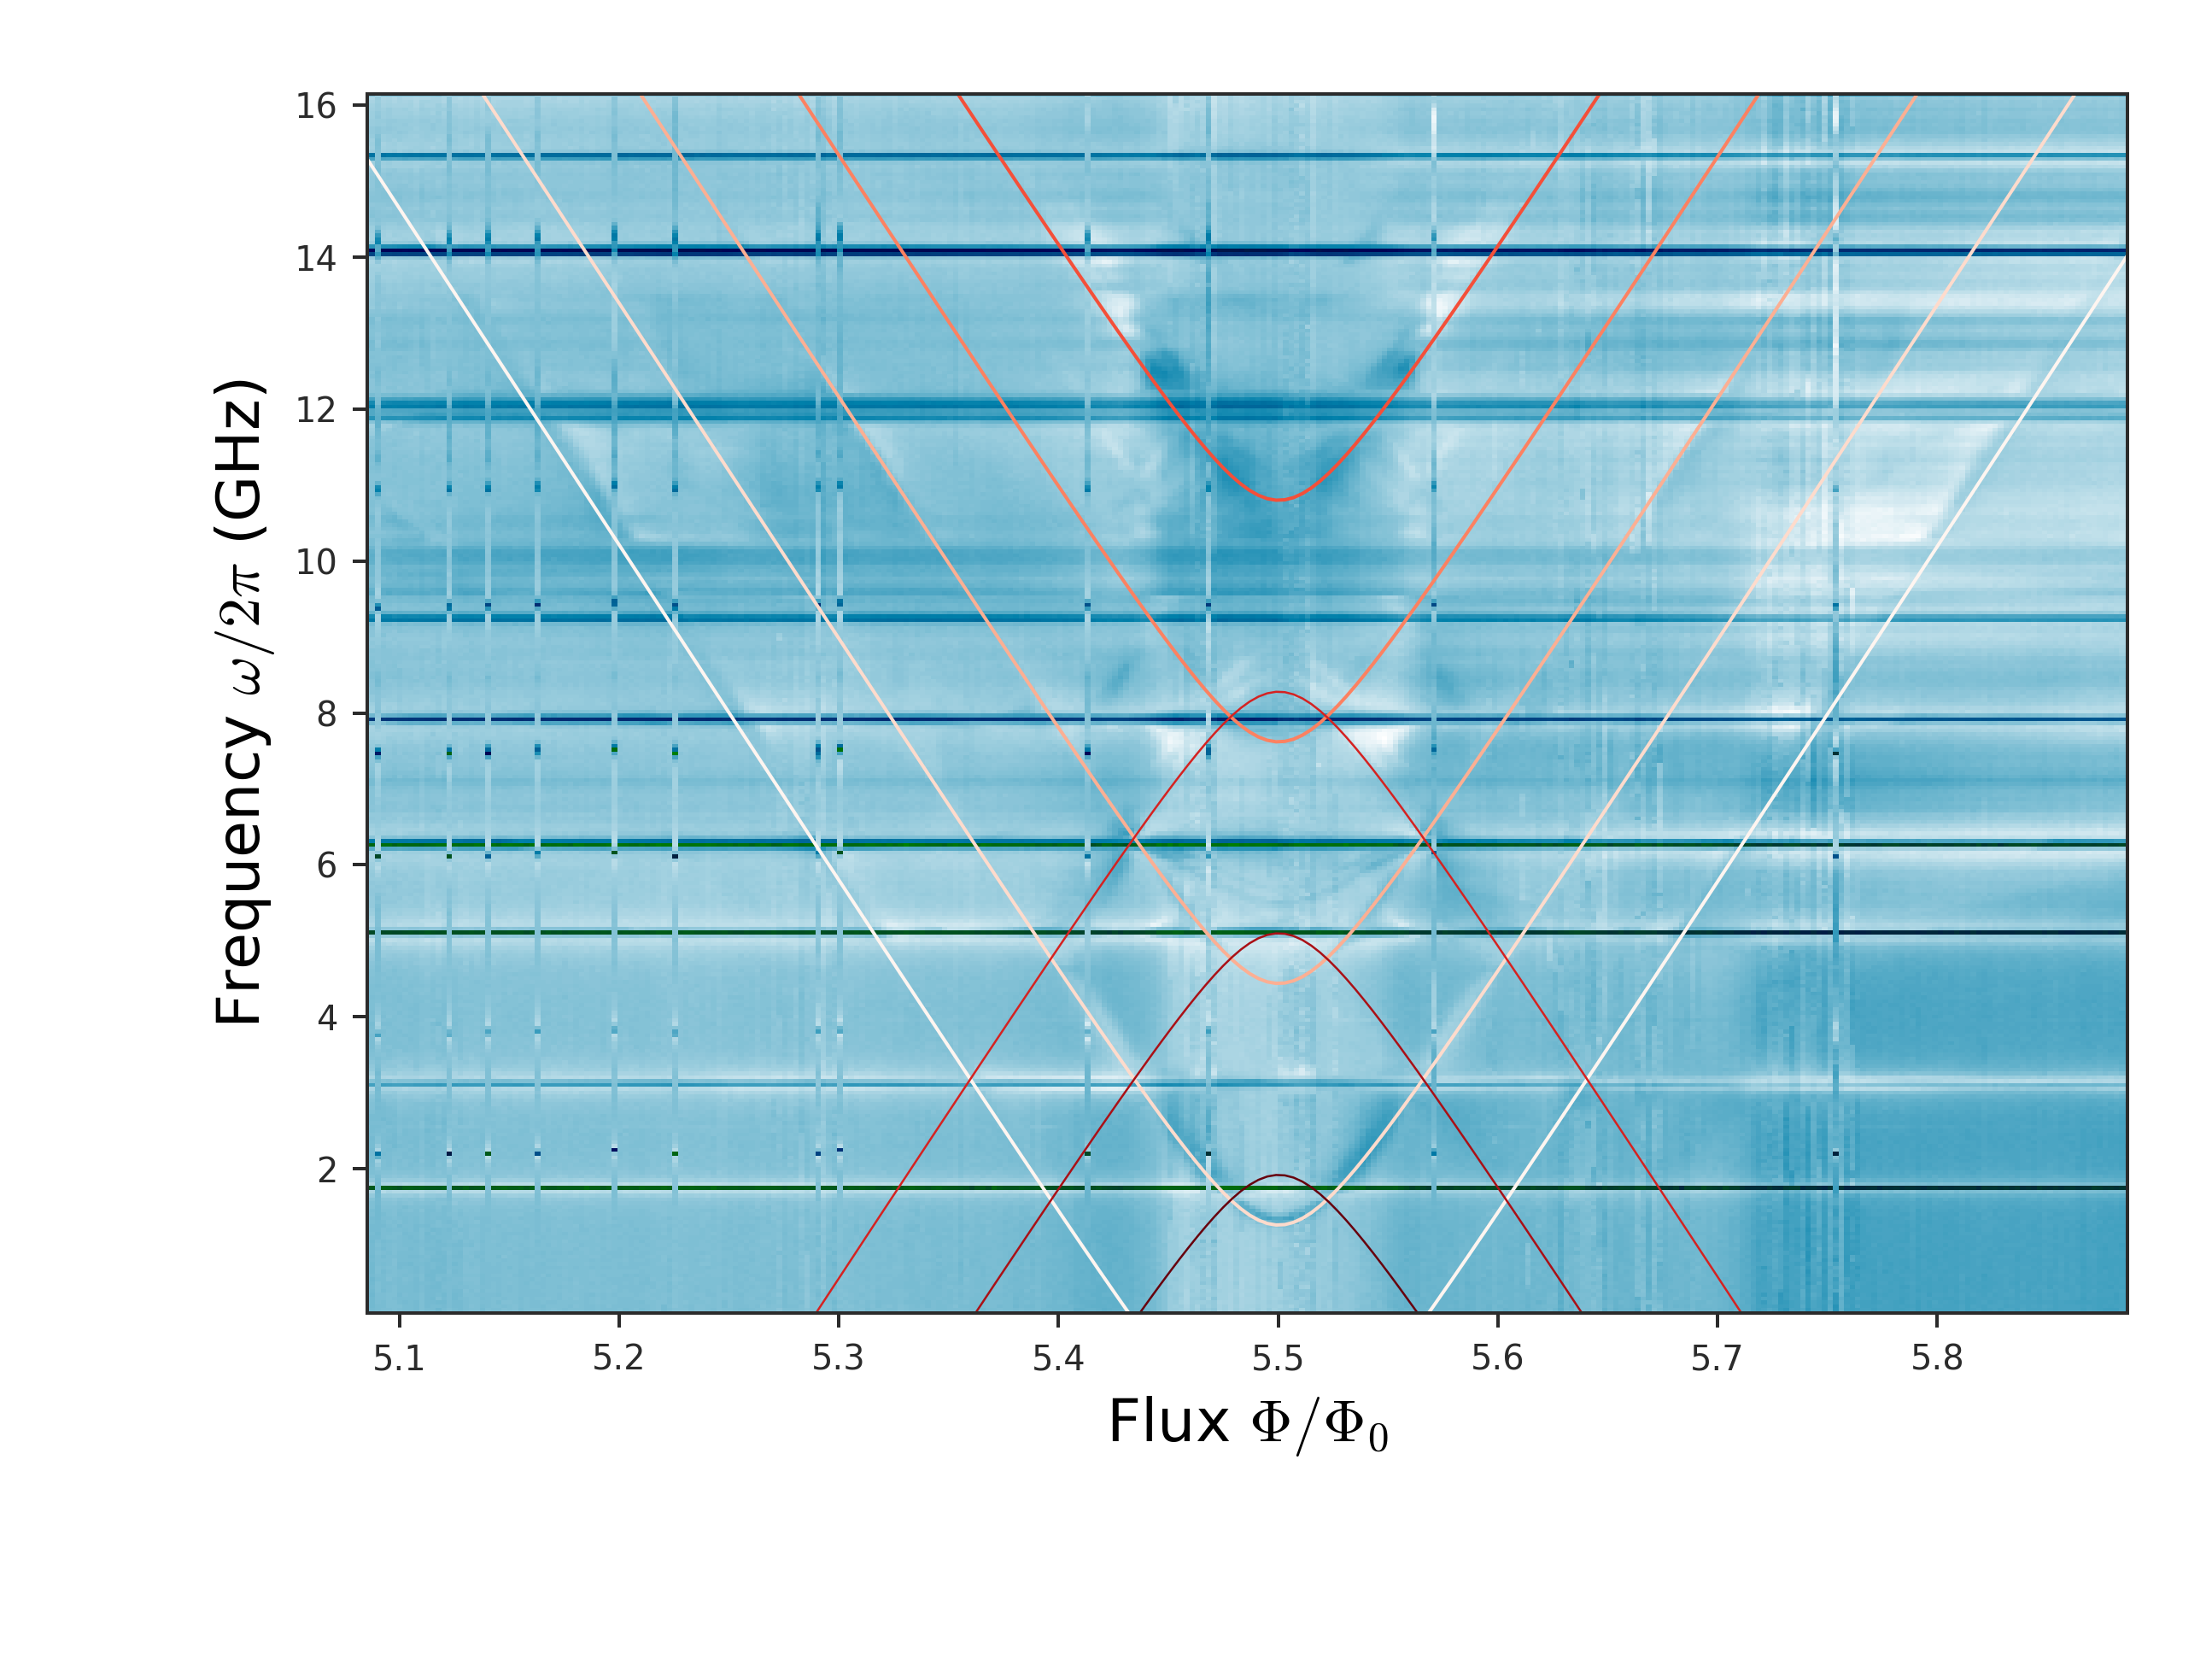

In [283]:
FLUX_NUMBER = np.linspace(4, 6, 500)
EL = 22.2
ES = 1.26

N_plots = 8
cmap = plt.cm.Reds(np.linspace(0, 1, N_plots))
resonator_f = 3.18

# Simulation
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

# We "can" look at the combined qubit-resonator system. But because we are NOT interested in the anticrossing feautes
# we can forget about the coupling and just write energy as sum of qubit and resonator energies
# (e_low, e_high) = qubit_resonator_spectrum(qubit_f01, resonator_f, g, N=0)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

col_idx = 0
simulation_graph, = ax.plot(FLUX_NUMBER, qubit_f01 - resonator_f, color=cmap[col_idx], linewidth=0.8); col_idx += 1
simulation_graph, = ax.plot(FLUX_NUMBER, qubit_f01, color=cmap[col_idx], linewidth=0.8); col_idx += 1
simulation_graph, = ax.plot(FLUX_NUMBER, qubit_f01 + resonator_f, color=cmap[col_idx], linewidth=0.8); col_idx += 1
simulation_graph, = ax.plot(FLUX_NUMBER, qubit_f01 + resonator_f + resonator_f, color=cmap[col_idx], linewidth=0.8); col_idx += 1
simulation_graph, = ax.plot(FLUX_NUMBER, qubit_f01 + resonator_f *3, color=cmap[col_idx], linewidth=0.8); col_idx += 1
simulation_graph, = ax.plot(FLUX_NUMBER, -qubit_f01 + 3*resonator_f, color=cmap[col_idx], linewidth=0.5); col_idx += 1
simulation_graph, = ax.plot(FLUX_NUMBER, -qubit_f01 + 2*resonator_f, color=cmap[col_idx], linewidth=0.5); col_idx += 1
simulation_graph, = ax.plot(FLUX_NUMBER, -qubit_f01 + 1*resonator_f, color=cmap[col_idx], linewidth=0.5); col_idx += 1

ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=plt.cm.ocean)

ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([min(data3d_y), max(data3d_y)])
ax.set_xlim([min(data3d_x), max(data3d_x)])
plt.tight_layout()

In [284]:
plt.savefig(FILENAME.replace(".txt", ".svg"))

# Qubit 12 Analysis
- Ay cell

In [10]:
# Global parameters
PERIOD = 0.1818 # Should not be changed

## Qubit spectrum

In [329]:
# FILENAME="./data/2020-07_cqps-single/two-tone/TiN95_CQPS_C_July12'20_two_tone_44_data.txt"
OFFSET = 0.1836 - PERIOD/2

FILENAME="./data/2020-07_cqps-single/two-tone/TiN95_CQPS_C_July12'20_two_tone_3G_102_data.txt"

# Load 3d data
with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x_raw = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = (data3d_x_raw - OFFSET) / PERIOD
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])
    
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)
FLUX_NUMBER = np.linspace(data3d_x[0], data3d_x[-1], 200)

<IPython.core.display.Javascript object>


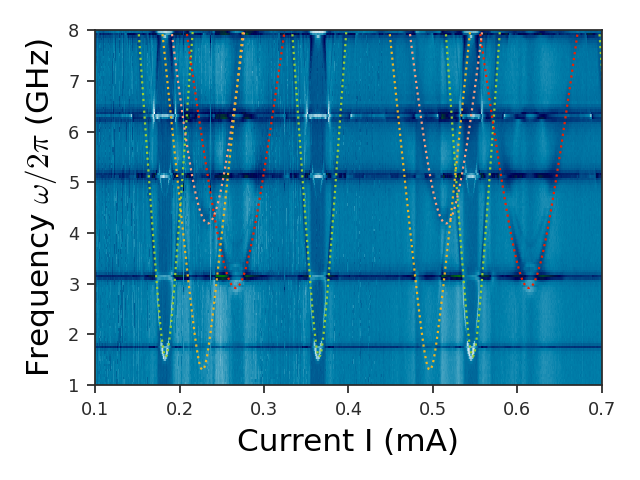

In [369]:
FLUX_NUMBER = np.linspace(0, 4, 500)
EL = 22.2
ES = 1.56

# Simulation
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, 2.92)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER/1.91, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit2_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, 4.2)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER/1.55, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit3_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, 1.3)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER/1.48, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit4_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
FLUX_NUMBER = FLUX_NUMBER * PERIOD + OFFSET
simulation_graph, = ax.plot(
    FLUX_NUMBER, qubit_f01, color=MY_COLOURS["Green"],
                            linestyle="dotted", linewidth=1)
ax.plot(FLUX_NUMBER, qubit2_f01, color=MY_COLOURS["DarkRed"],
       linestyle="dotted", linewidth=1)
ax.plot(FLUX_NUMBER, qubit3_f01, color=MY_COLOURS["Pink"],
       linestyle="dotted", linewidth=1)
ax.plot(FLUX_NUMBER, qubit4_f01, color="#eeb422",
       linestyle="dotted", linewidth=1)

# ax.plot(field, response,
#         linestyle="", markersize=3,
#         marker="o", color="orange")
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x_raw, data3d_y)

ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=plt.cm.ocean_r)

ax.set_xlabel("Current I (mA)")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([1, 8])
ax.set_xlim([0.1, 0.7])
plt.tight_layout()

In [8]:
def update(ES: float, EL: float, toggle: bool):    
    cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)

    simulation = cqps_qubit.run_simulation(
        FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
    qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

    simulation_graph.set_ydata(qubit_f01)
    simulation_graph.set_visible(toggle)
    ax.relim()
    ax.autoscale_view()
    plt.tight_layout()
    
ES_widget = ipywidgets.FloatSlider(
    min=0, max=10, step=0.1,
    description="$ES (GHZ)$", value=ES,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=True
)
EL_widget = ipywidgets.FloatSlider(
    min=0, max=30, step=0.1,
    description="$EL (GHz)$", value=EL,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=True
)
toggle_widget = ipywidgets.Checkbox(
    description='Show/Hide Fit',
    value=True
)

ui = ipywidgets.GridspecLayout(3, 1)
ui[0,0] = ES_widget
ui[1,0] = EL_widget
ui[2,0] = toggle_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "ES": ES_widget,
        "EL": EL_widget,
        "toggle": toggle_widget
    }
)  

display(ui, out)

GridspecLayout(children=(FloatSlider(value=1.56, description='$ES (GHZ)$', layout=Layout(grid_area='widget001'…

Output()

In [370]:
plt.savefig(FILENAME.replace("txt","png"), dpi=600)
# plt.savefig(FILENAME.replace("txt","svg"))

### Linewidth

  \begin{equation}
    L(x)      =      L_0\frac{1}{\pi}\frac{\frac{1}{2}\xi}{\big(\frac{1}{2}\xi\big)^2+(x-x_0)^2}\quad\quad
    V_\text{max} =  \frac{2}{\pi\xi} = 2V_0T_1\quad\quad\text{FWHM}  = \xi \text{(x-scale)}  = \frac{2}{T}
    \text{($ \omega $-scale)}
  \end{equation}

[1.26947330e-03 1.38323833e-02 1.52724498e+00 9.93405756e-01]
Gamma/2pi = 13.832383348752703 -> Gamma = 86.91142782015855


<IPython.core.display.Javascript object>


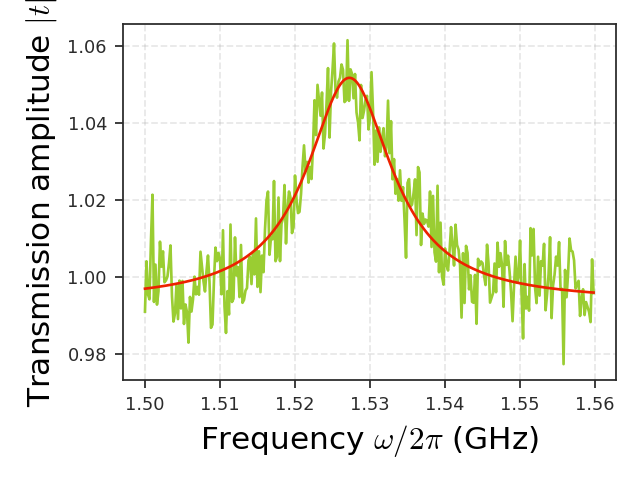

In [372]:
FILENAME = "./data/2020-07_cqps-single/two-tone/TiN95_CQPS_C_July12'20_two_tone_3G_Q12_HD_91_data.txt"

data = np.loadtxt(FILENAME, skiprows=1)
data_x = data[:, 0][:300]
data_y = data[:, 1][:300]

def lorentzian(x, A, width, center, offset):
    width_over_2 = width/2
    return A / np.pi * width_over_2 / (width_over_2**2 + (x-center)**2) + offset

popt, _ = curve_fit(
    lorentzian, 
    data_x, 
    data_y,
    p0 = [
        0.06,
        0.025,
        1.525,
        1
    ]
)
print(popt)
print(f"Gamma/2pi = {popt[1]*1000} -> Gamma = {popt[1]*1000*2*np.pi}")


fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(data_x, data_y, color=MY_COLOURS["Green"])
ax.plot(data_x, lorentzian(data_x, *popt), color=MY_COLOURS["DarkRed"])

# ax.plot(field, response,
#         linestyle="", markersize=3,
#         marker="o", color="orange")
# ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
#               shading='nearest',
#               cmap=plt.cm.ocean)
ax.set_xlabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylabel("Transmission amplitude $|t|$")
# ax.set_ylim([1, 8])
# ax.set_xlim([1, 5])
plt.tight_layout()

plt.savefig(FILENAME.replace(".txt", ".svg"))

## Anticrossing on m=2
- g = 29.9MHz
- $\Gamma$ effects the "sharpness" of the up/down cliffs. Very on the eye - we should probably fit it from the qubit linewidth
- Resonator parameters taken from Teresa's fittings

In [399]:
FILENAME="./data/2020-07_cqps-single/anticrossing/TiN95_CQPS_C_July12'20_mfield-3_13G_18_data.txt"
# FILENAME="./data/CQPS paper/TiN95_CQPS_C_July12'20_mfield-3_13G_18_data.txt"
OFFSET = 1.4566 - PERIOD/2

EL = 22.2
ES = 1.56
resonator_f = 3.13461 #GHz
kappa = 2.07 #MHz

# These are in MHz
g = 29.9
Gamma1 = 20
GammaPhi = 0

# Load 3d data
with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = (data3d_x - OFFSET) / PERIOD
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])

# Build meshes and arrays based of the ranges in the file
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)
FLUX_NUMBER = np.linspace(data3d_x[0], data3d_x[-1], 200)
sweep_f = np.linspace(data3d_y[0], data3d_y[-1], 200)
deltaXMesh, deltaYMesh = np.meshgrid(FLUX_NUMBER, sweep_f)

0


<IPython.core.display.Javascript object>


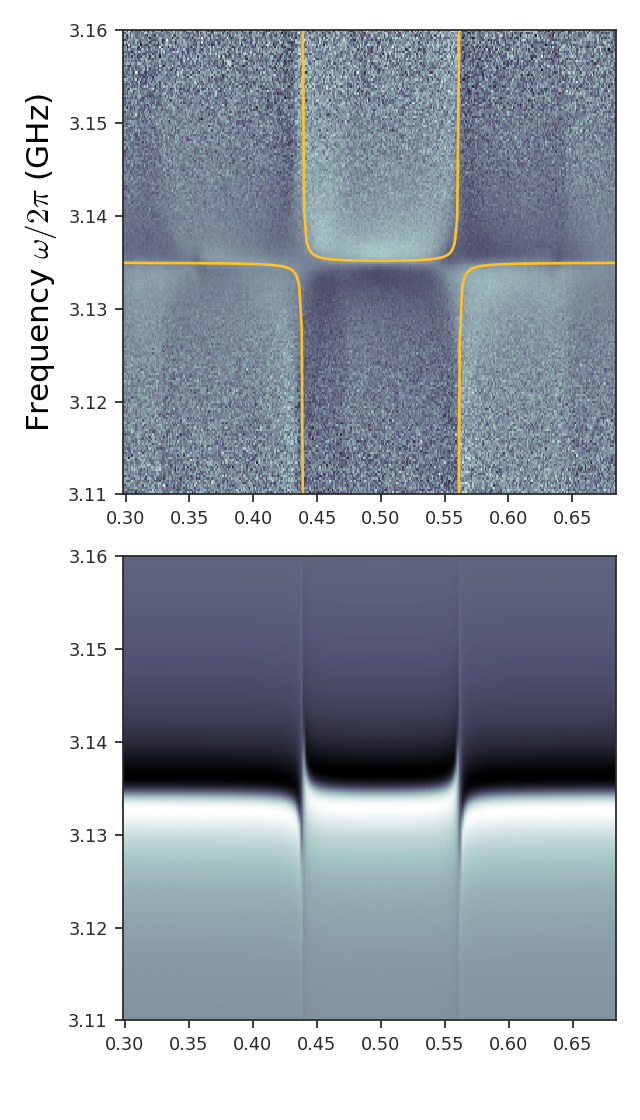

In [400]:
# Qubit
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

# Resonator-qubit
(e_low, e_high) = qubit_resonator_spectrum(qubit_f01, resonator_f,
                                           g/1000  # convert to GHz
                                           )

# For master equation simulation
deltaQ = []
deltaR = []
for fq in qubit_f01:
    deltaQ.append(sweep_f - fq)
    deltaR.append(sweep_f - resonator_f)
deltaQ = np.array(deltaQ)*1000  # to convert from GHz to MHz
deltaR = np.array(deltaR)*1000

transmission_function = make_transmission_function(
    Gamma1, GammaPhi, kappa, g)
tMesh = transmission_function(deltaQ, deltaR)

# Plot
fig, ax_arr = plt.subplots(2, 1, figsize=(4, 7))
ax = ax_arr[0]
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=plt.cm.bone)
e_low_plot, = ax.plot(FLUX_NUMBER, e_low, color=MY_COLOURS["Orange"])
e_high_plot, = ax.plot(FLUX_NUMBER, e_high, color=MY_COLOURS["Orange"])
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([data3d_y[0], data3d_y[-1]])

ax = ax_arr[1]
ax.pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tMesh), 
              shading='gouraud', 
            cmap=plt.cm.bone)
ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")

# ax = ax_arr[2]
# ax.plot(FLUX_NUMBER, qubit_f01, color=MY_COLOURS["Green"],
#         linestyle="-", linewidth=6, alpha=0.5, label="Qubit Spectrum")
# e_low_plot_LARGE, = ax.plot(FLUX_NUMBER, e_low,
#                             color=MY_COLOURS["Orange"])
# e_high_plot_LARGE, = ax.plot(FLUX_NUMBER, e_high,
#                              color=MY_COLOURS["Orange"],
#                              label="Qubit-Resonator"
#                              )
# ax.set_xlabel("Flux $\Phi/\Phi_0$")
# ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
# ax.legend()

plt.tight_layout()

In [403]:
def update(g: float, resonator_f: float, Gamma: float, kappa: float, toggle: bool):
    # Pass in g in MHz
    (e_low, e_high) = qubit_resonator_spectrum(qubit_f01, 
                                               resonator_f, 
                                               g/1000)
    e_low_plot.set_ydata(e_low)
    e_high_plot.set_ydata(e_high)    
#     e_low_plot_LARGE.set_ydata(e_low)
#     e_high_plot_LARGE.set_ydata(e_high)
    
    e_low_plot.set_visible(toggle)
    e_high_plot.set_visible(toggle)        

    transmission_function = make_transmission_function(Gamma, 0, kappa, g)
    tMesh = transmission_function(deltaQ, deltaR)
    ax_arr[1].clear()
    ax_arr[1].pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tMesh), 
              shading='gouraud', 
            cmap=plt.cm.bone)
CONTINOUS_UPDATE = False    
g_widget = ipywidgets.FloatSlider(
    min=0, max=200, step=0.05,
    description="$g/2\pi (MHz)$", value=g,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
resonator_widget = ipywidgets.FloatSlider(
    min=3.12, max=3.14, step=0.005,
    description="$f_r (GHz)$", value=resonator_f,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
Gamma_widget = ipywidgets.FloatSlider(
    min=0, max=200, step=0.1,
    description="$\Gamma (MHz)$", value=Gamma1,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
kappa_widget = ipywidgets.FloatSlider(
    min=0, max=20, step=0.1,
    description="$\kappa (MHz)$", value=kappa,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
toggle_widget = ipywidgets.Checkbox(
    description='Show/Hide Fit',
    value=True
)

ui = ipywidgets.GridspecLayout(4, 2)
ui[0,:] = resonator_widget
ui[1,:] = g_widget
ui[2,0] = Gamma_widget
ui[2,1] = kappa_widget
ui[3,:] = toggle_widget


out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "g": g_widget, "resonator_f": resonator_widget, "toggle": toggle_widget,
        "Gamma": Gamma_widget, "kappa": kappa_widget
    }
)  

display(ui, out)

GridspecLayout(children=(FloatSlider(value=3.13461, continuous_update=False, description='$f_r (GHz)$', layout…

Output()

In [22]:
plt.savefig(FILENAME.replace("txt","pdf"),dpi=100)

## Anticrossing on m=3
- g = 29.9MHz
- $\Gamma$ effects the "sharpness" of the up/down cliffs. Very on the eye - we should probably fit it from the qubit linewidth

In [23]:
FILENAME="./data/2020-07_cqps-single/anticrossing/TiN95_CQPS_C_July12'20_mfield-5_12G_16_data.txt"
# FILENAME="./data/CQPS paper/TiN95_CQPS_C_July12'20_mfield-5_12G_16_data.txt"
OFFSET = 1.4566 - PERIOD/2

resonator_f = 5.12 #GHz
kappa = 4.75 #MHz

# These are in MHz
g = 20
Gamma1 = 22
GammaPhi = 0

# Load 3d data
with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = (data3d_x - OFFSET) / PERIOD
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])

# Build meshes and arrays based of the ranges in the file
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)
FLUX_NUMBER = np.linspace(data3d_x[0], data3d_x[-1], 200)
sweep_f = np.linspace(data3d_y[0], data3d_y[-1], 200)
deltaXMesh, deltaYMesh = np.meshgrid(FLUX_NUMBER, sweep_f)

0


<IPython.core.display.Javascript object>


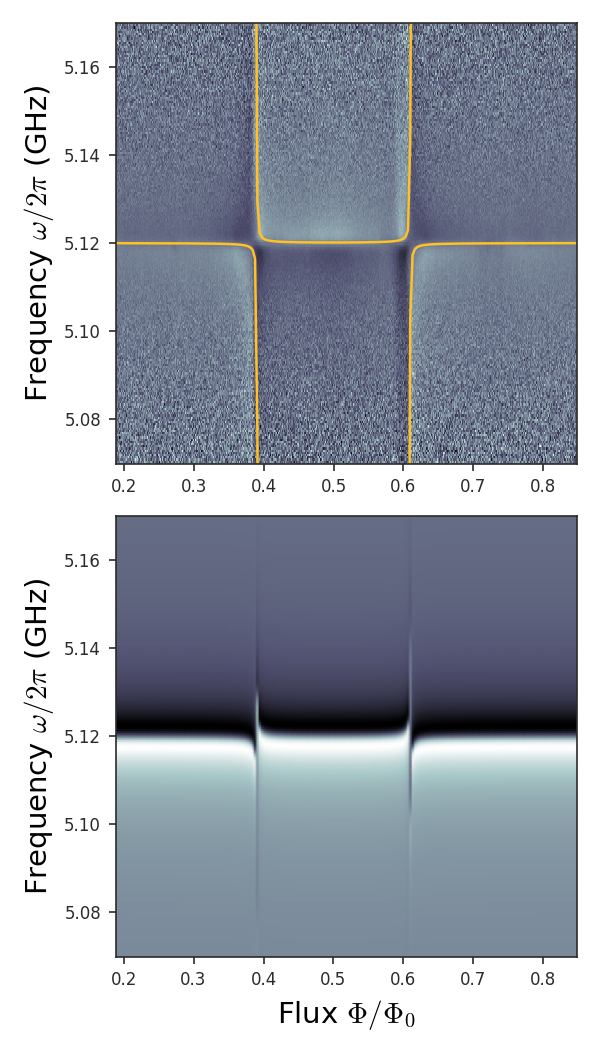

In [26]:
# Qubit
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

# Resonator-qubit
(e_low, e_high) = qubit_resonator_spectrum(qubit_f01, resonator_f,
                                           g/1000  # convert to GHz
                                           )

# For master equation simulation
deltaQ = []
deltaR = []
for fq in qubit_f01:
    deltaQ.append(sweep_f - fq)
    deltaR.append(sweep_f - resonator_f)
deltaQ = np.array(deltaQ)*1000  # to convert from GHz to MHz
deltaR = np.array(deltaR)*1000

transmission_function = make_transmission_function(
    Gamma1, GammaPhi, kappa, g)
tMesh = transmission_function(deltaQ, deltaR)

# Plot
fig, ax_arr = plt.subplots(2, 1, figsize=(4, 7))
ax = ax_arr[0]
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=plt.cm.bone)
e_low_plot, = ax.plot(FLUX_NUMBER, e_low, color=MY_COLOURS["Orange"])
e_high_plot, = ax.plot(FLUX_NUMBER, e_high, color=MY_COLOURS["Orange"])
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([data3d_y[0], data3d_y[-1]])

ax = ax_arr[1]
ax.pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tMesh), 
              shading='gouraud', 
            cmap=plt.cm.bone)
ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")

# ax = ax_arr[2]
# ax.plot(FLUX_NUMBER, qubit_f01, color=MY_COLOURS["Green"],
#         linestyle="-", linewidth=6, alpha=0.5, label="Qubit Spectrum")
# e_low_plot_LARGE, = ax.plot(FLUX_NUMBER, e_low,
#                             color=MY_COLOURS["Orange"])
# e_high_plot_LARGE, = ax.plot(FLUX_NUMBER, e_high,
#                              color=MY_COLOURS["Orange"],
#                              label="Qubit-Resonator"
#                              )
# ax.set_xlabel("Flux $\Phi/\Phi_0$")
# ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
# ax.legend()

plt.tight_layout()

In [ ]:
def update(g: float, resonator_f: float, Gamma: float, kappa: float, toggle: bool):
    # Pass in g in MHz
    (e_low, e_high) = qubit_resonator_spectrum(qubit_f01, 
                                               resonator_f, 
                                               g/1000)
    e_low_plot.set_ydata(e_low)
    e_high_plot.set_ydata(e_high)    
    e_low_plot_LARGE.set_ydata(e_low)
    e_high_plot_LARGE.set_ydata(e_high)
    
    e_low_plot.set_visible(toggle)
    e_high_plot.set_visible(toggle)        

    transmission_function = make_transmission_function(Gamma, 0, kappa, g)
    tMesh = transmission_function(deltaQ, deltaR)
    ax_arr[1].clear()
    ax_arr[1].pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tMesh), 
              shading='gouraud', 
            cmap=plt.cm.bone)
CONTINOUS_UPDATE = False    
g_widget = ipywidgets.FloatSlider(
    min=0, max=200, step=0.05,
    description="$g/2\pi (MHz)$", value=g,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
resonator_widget = ipywidgets.FloatSlider(
    min=resonator_f*0.9, max=resonator_f*1.1, step=0.005,
    description="$f_r (GHz)$", value=resonator_f,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
Gamma_widget = ipywidgets.FloatSlider(
    min=0, max=200, step=0.1,
    description="$\Gamma (MHz)$", value=Gamma1,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
kappa_widget = ipywidgets.FloatSlider(
    min=0, max=20, step=0.1,
    description="$\kappa (MHz)$", value=kappa,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
toggle_widget = ipywidgets.Checkbox(
    description='Show/Hide Fit',
    value=True
)

ui = ipywidgets.GridspecLayout(4, 2)
ui[0,:] = resonator_widget
ui[1,:] = g_widget
ui[2,0] = Gamma_widget
ui[2,1] = kappa_widget
ui[3,:] = toggle_widget


out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "g": g_widget, "resonator_f": resonator_widget, "toggle": toggle_widget,
        "Gamma": Gamma_widget, "kappa": kappa_widget
    }
)  

display(ui, out)

In [27]:
plt.savefig(FILENAME.replace("txt","pdf"),dpi=100)

## Anitcrossing on m=4
- $g$ hard to define
- $\Gamma$ effects the "sharpness" of the up/down cliffs. Very on the eye - we should probably fit it from the qubit linewidth

In [28]:
FILENAME="./data/2020-07_cqps-single/anticrossing/TiN95_CQPS_C_July12'20_mfield-6_3G_m15dBm_43_data.txt"
# FILENAME="./data/CQPS paper/TiN95_CQPS_C_July12'20_mfield-6_3G_m15dBm_43_data.txt"
OFFSET = 0.1836 - PERIOD/2

resonator_f = 6.28143 #GHz
kappa = 8.5 #MHz

# These are in MHz
g = 20
Gamma1 = 22
GammaPhi = 0

# Load 3d data
with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = (data3d_x - OFFSET) / PERIOD
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])

# Build meshes and arrays based of the ranges in the file
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)
FLUX_NUMBER = np.linspace(data3d_x[0], data3d_x[-1], 200)
sweep_f = np.linspace(data3d_y[0], data3d_y[-1], 200)
deltaXMesh, deltaYMesh = np.meshgrid(FLUX_NUMBER, sweep_f)

0


<IPython.core.display.Javascript object>


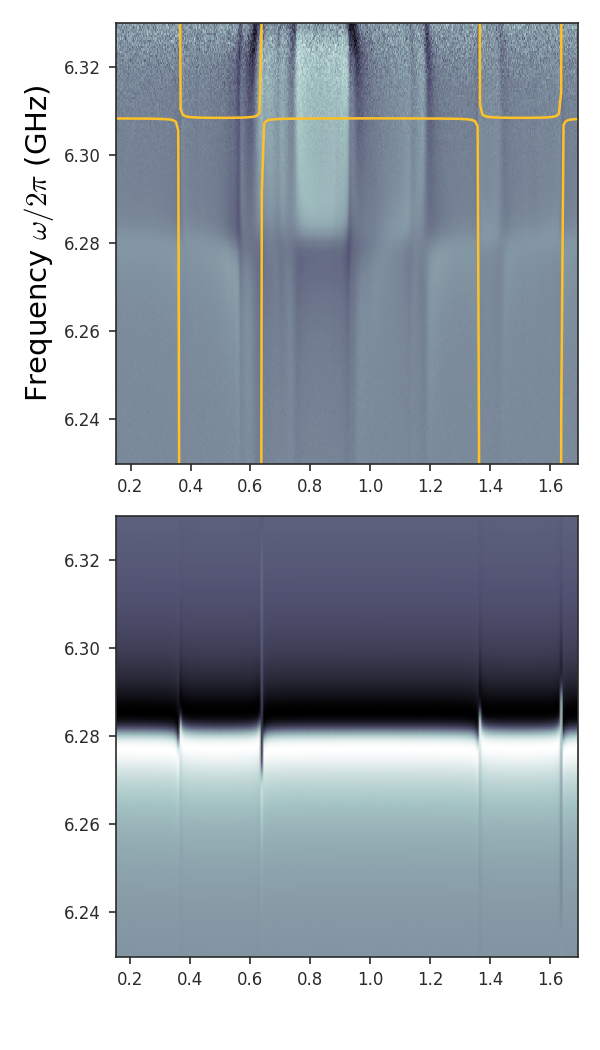

In [30]:
# Qubit
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

# Resonator-qubit
(e_low, e_high) = qubit_resonator_spectrum(qubit_f01, resonator_f,
                                           g/1000  # convert to GHz
                                           )

# For master equation simulation
deltaQ = []
deltaR = []
for fq in qubit_f01:
    deltaQ.append(sweep_f - fq)
    deltaR.append(sweep_f - resonator_f)
deltaQ = np.array(deltaQ)*1000  # to convert from GHz to MHz
deltaR = np.array(deltaR)*1000

transmission_function = make_transmission_function(
    Gamma1, GammaPhi, kappa, g)
tMesh = transmission_function(deltaQ, deltaR)

# Plot
fig, ax_arr = plt.subplots(2, 1, figsize=(4, 7))
ax = ax_arr[0]
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=plt.cm.bone)
e_low_plot, = ax.plot(FLUX_NUMBER, e_low, color=MY_COLOURS["Orange"])
e_high_plot, = ax.plot(FLUX_NUMBER, e_high, color=MY_COLOURS["Orange"])
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([data3d_y[0], data3d_y[-1]])

ax = ax_arr[1]
ax.pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tMesh), 
              shading='gouraud', 
            cmap=plt.cm.bone)
ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")

# ax = ax_arr[2]
# ax.plot(FLUX_NUMBER, qubit_f01, color=MY_COLOURS["Green"],
#         linestyle="-", linewidth=6, alpha=0.5, label="Qubit Spectrum")
# e_low_plot_LARGE, = ax.plot(FLUX_NUMBER, e_low,
#                             color=MY_COLOURS["Orange"])
# e_high_plot_LARGE, = ax.plot(FLUX_NUMBER, e_high,
#                              color=MY_COLOURS["Orange"],
#                              label="Qubit-Resonator"
#                              )
# ax.set_xlabel("Flux $\Phi/\Phi_0$")
# ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
# ax.legend()

plt.tight_layout()

In [32]:
def update(g: float, resonator_f: float, Gamma: float, kappa: float, toggle: bool):
    # Pass in g in MHz
    (e_low, e_high) = qubit_resonator_spectrum(qubit_f01, 
                                               resonator_f, 
                                               g/1000)
    e_low_plot.set_ydata(e_low)
    e_high_plot.set_ydata(e_high)    
    e_low_plot_LARGE.set_ydata(e_low)
    e_high_plot_LARGE.set_ydata(e_high)
    
    e_low_plot.set_visible(toggle)
    e_high_plot.set_visible(toggle)        

    transmission_function = make_transmission_function(Gamma, 0, kappa, g)
    tMesh = transmission_function(deltaQ, deltaR)
    ax_arr[1].clear()
    ax_arr[1].pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tMesh), 
              shading='gouraud', 
            cmap=plt.cm.bone)
CONTINOUS_UPDATE = False    
g_widget = ipywidgets.FloatSlider(
    min=0, max=200, step=0.05,
    description="$g/2\pi (MHz)$", value=g,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
resonator_widget = ipywidgets.FloatSlider(
    min=resonator_f*0.9, max=resonator_f*1.1, step=0.005,
    description="$f_r (GHz)$", value=resonator_f,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
Gamma_widget = ipywidgets.FloatSlider(
    min=0, max=200, step=0.1,
    description="$\Gamma (MHz)$", value=Gamma1,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
kappa_widget = ipywidgets.FloatSlider(
    min=0, max=20, step=0.1,
    description="$\kappa (MHz)$", value=kappa,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
toggle_widget = ipywidgets.Checkbox(
    description='Show/Hide Fit',
    value=True
)

ui = ipywidgets.GridspecLayout(4, 2)
ui[0,:] = resonator_widget
ui[1,:] = g_widget
ui[2,0] = Gamma_widget
ui[2,1] = kappa_widget
ui[3,:] = toggle_widget


out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "g": g_widget, "resonator_f": resonator_widget, "toggle": toggle_widget,
        "Gamma": Gamma_widget, "kappa": kappa_widget
    }
)  

display(ui, out)

GridspecLayout(children=(FloatSlider(value=6.28143, continuous_update=False, description='$f_r (GHz)$', layout…

Output()

## Anitcrossing on m=5
- g = 44MHz
- $\Gamma$ effects the "sharpness" of the up/down cliffs. Very on the eye - we should probably fit it from the qubit linewidth

In [33]:
FILENAME="./data/2020-07_cqps-single/anticrossing/TiN95_CQPS_C_July12'20_mfield-7_9G_m15dBm_38_data.txt"
# FILENAME="./data/CQPS paper/TiN95_CQPS_C_July12'20_mfield-7_9G_m15dBm_38_data.txt"

OFFSET = 0.1836 - PERIOD/2

resonator_f = 7.9395 #GHz
kappa = 11.1 #MHz

# These are in MHz
g = 44
Gamma1 = 22
GammaPhi = 0

# Load 3d data
with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = (data3d_x - OFFSET) / PERIOD
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])

# Build meshes and arrays based of the ranges in the file
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)
FLUX_NUMBER = np.linspace(data3d_x[0], data3d_x[-1], 200)
sweep_f = np.linspace(data3d_y[0], data3d_y[-1], 200)
deltaXMesh, deltaYMesh = np.meshgrid(FLUX_NUMBER, sweep_f)

0


<IPython.core.display.Javascript object>


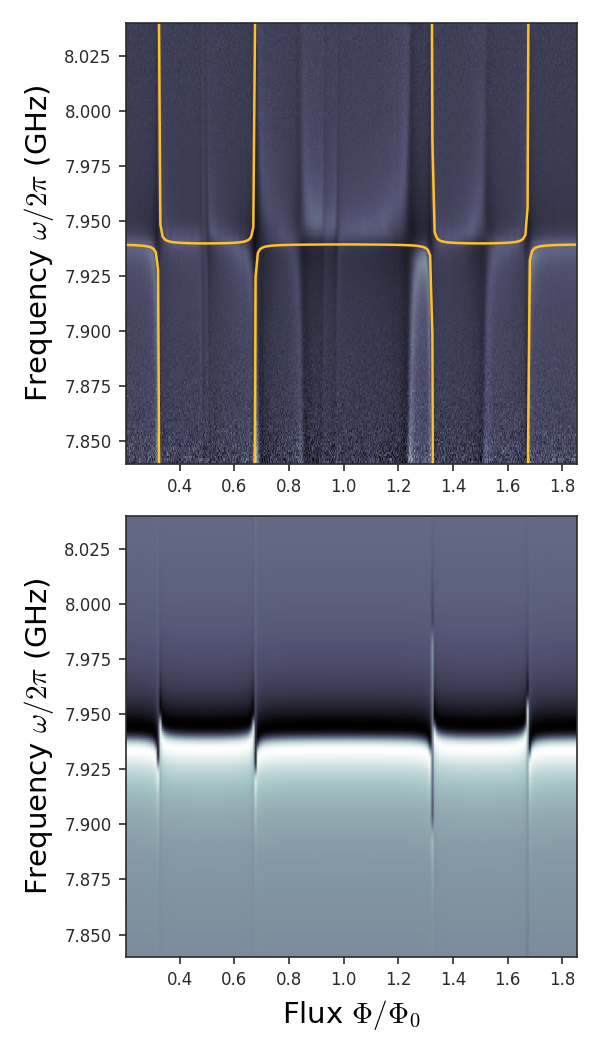

In [35]:
# Qubit
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

# Resonator-qubit
(e_low, e_high) = qubit_resonator_spectrum(qubit_f01, resonator_f,
                                           g/1000  # convert to GHz
                                           )

# For master equation simulation
deltaQ = []
deltaR = []
for fq in qubit_f01:
    deltaQ.append(sweep_f - fq)
    deltaR.append(sweep_f - resonator_f)
deltaQ = np.array(deltaQ)*1000  # to convert from GHz to MHz
deltaR = np.array(deltaR)*1000

transmission_function = make_transmission_function(
    Gamma1, GammaPhi, kappa, g)
tMesh = transmission_function(deltaQ, deltaR)

# Plot
fig, ax_arr = plt.subplots(2, 1, figsize=(4, 7))
ax = ax_arr[0]
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=plt.cm.bone)
e_low_plot, = ax.plot(FLUX_NUMBER, e_low, color=MY_COLOURS["Orange"])
e_high_plot, = ax.plot(FLUX_NUMBER, e_high, color=MY_COLOURS["Orange"])
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([data3d_y[0], data3d_y[-1]])

ax = ax_arr[1]
ax.pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tMesh), 
              shading='gouraud', 
            cmap=plt.cm.bone)
ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")

# ax = ax_arr[2]
# ax.plot(FLUX_NUMBER, qubit_f01, color=MY_COLOURS["Green"],
#         linestyle="-", linewidth=6, alpha=0.5, label="Qubit Spectrum")
# e_low_plot_LARGE, = ax.plot(FLUX_NUMBER, e_low,
#                             color=MY_COLOURS["Orange"])
# e_high_plot_LARGE, = ax.plot(FLUX_NUMBER, e_high,
#                              color=MY_COLOURS["Orange"],
#                              label="Qubit-Resonator"
#                              )
# ax.set_xlabel("Flux $\Phi/\Phi_0$")
# ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
# ax.legend()

plt.tight_layout()

In [ ]:
plt.def update(g: float, resonator_f: float, Gamma: float, kappa: float, toggle: bool):
    # Pass in g in MHz
    (e_low, e_high) = qubit_resonator_spectrum(qubit_f01, 
                                               resonator_f, 
                                               g/1000)
    e_low_plot.set_ydata(e_low)
    e_high_plot.set_ydata(e_high)    
    e_low_plot_LARGE.set_ydata(e_low)
    e_high_plot_LARGE.set_ydata(e_high)
    
    e_low_plot.set_visible(toggle)
    e_high_plot.set_visible(toggle)        

    transmission_function = make_transmission_function(Gamma, 0, kappa, g)
    tMesh = transmission_function(deltaQ, deltaR)
    ax_arr[1].clear()
    ax_arr[1].pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tMesh), 
              shading='gouraud', 
            cmap=plt.cm.bone)
CONTINOUS_UPDATE = False    
g_widget = ipywidgets.FloatSlider(
    min=0, max=200, step=0.05,
    description="$g/2\pi (MHz)$", value=g,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
resonator_widget = ipywidgets.FloatSlider(
    min=resonator_f*0.9, max=resonator_f*1.1, step=0.005,
    description="$f_r (GHz)$", value=resonator_f,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
Gamma_widget = ipywidgets.FloatSlider(
    min=0, max=200, step=0.1,
    description="$\Gamma (MHz)$", value=Gamma1,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
kappa_widget = ipywidgets.FloatSlider(
    min=0, max=20, step=0.1,
    description="$\kappa (MHz)$", value=kappa,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
toggle_widget = ipywidgets.Checkbox(
    description='Show/Hide Fit',
    value=True
)

ui = ipywidgets.GridspecLayout(4, 2)
ui[0,:] = resonator_widget
ui[1,:] = g_widget
ui[2,0] = Gamma_widget
ui[2,1] = kappa_widget
ui[3,:] = toggle_widget


out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "g": g_widget, "resonator_f": resonator_widget, "toggle": toggle_widget,
        "Gamma": Gamma_widget, "kappa": kappa_widget
    }
)  

display(ui, out)

## Anticrossing summary
Since we have
\begin{equation}
 g = \frac{\pi{E_s}C_{q-r}}{2e}\sqrt{\frac{\hbar\omega_r}{C_r}}\cos(n\pi{\frac{x}{L}})
\end{equation}

We should be able to plot g vs $\sqrt{nf_{fundametal}}\cos(n\pi{\frac{x}{L}})$ with
- $L=1140$
- $x = L/2 + 69.5$
- $f_{fundametal}=3.13461\text{GHz}/2$

<IPython.core.display.Javascript object>


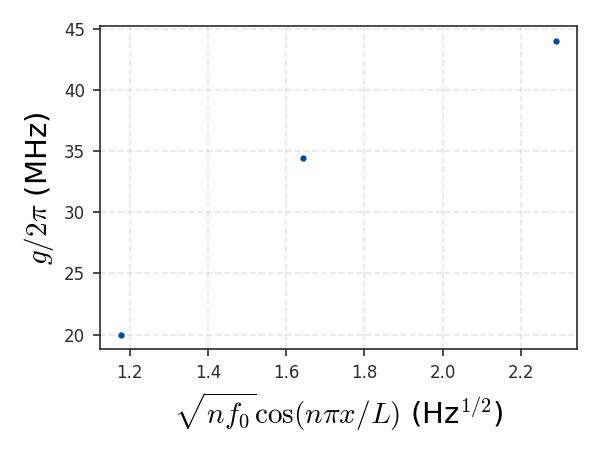

In [36]:
f_fundametal = 3.13461/2 #GHz
L = 1140 #µm
qubit_position = 1/2 + 69.5/L
g_solutions = {
    2: 34.45,
    3: 20,
    5: 44
}

# Generate plot data
x_values = [
    (
        np.sqrt(n*f_fundametal) 
        * np.abs(np.cos(n*np.pi*qubit_position))
    )
    for n in g_solutions.keys()
     ]
y_values = g_solutions.values()

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(x_values, y_values, linestyle="", marker="o")
ax.set_xlabel("$\sqrt{nf_0}\cos(n\pi{x}/L)$ (Hz$^{1/2}$)")
ax.set_ylabel("$g/2\pi$ (MHz)")
plt.tight_layout()

In [ ]:
plt.savefig("data/2020-07_cqps-single/qubit12_g-from-anticrossing.pdf",dpi=100)

# Estimating $E_s$ values
There are a range of different ways to evaluate the $E_c$ value.

In [2]:
# Measured during cooldown TiN95_CQPS_DC_Apr12'19_Tdep_extract.vi on a 80x20µm bar
R_square = 2.04*kOhm / 4
Tc_TiN = 1.7

# Derived
Delta = 1.784*kb*Tc_TiN
L_square = hbar * R_square / np.pi / Delta # Kinetic inductance

# Knowing the frequency of the resonator, we can approximate it's capacitance per square (resonator width is 5µm):
f_resonator = 3.14*GHz / 2 # As this is the second mode
C_square = 1/f_resonator**2/L_square

print(f"""
L_square = {L_square/nH:.2f}nH
C_square (5µm) = {C_square/nF:.2f}nF
""")


L_square = 0.41nH
C_square (5µm) = 0.99nF



## Sebastien de Graff and Sebastien Skatcel
 \begin{equation}
     \begin{aligned}
      E_s & = \Delta \sqrt{\frac{L}{\xi}}\frac{R_{Q}}{R_\xi} \text{exp}\left(-a\frac{R_{Q}}{R_\xi}\right) \\
      a & \approx 0.36 \\
      R_\xi & \text{ normal state resistance of wire segment of length } \xi\\
      R_{Q} & = \frac{h}{4e^{2}} \\
     \end{aligned}
 \end{equation}

In [17]:
# Sebastien paper: 2018_degraf_charge-control-of-blockade-of-cooper-pair-tunnelling-in-highly-disordered-TiN-nanowires-in-an-inductive-environment.pdf
# Also used titanium Nitride
a = 0.36

# All length units in nm
width = 10
L = 50 #nm
coherence_length = 4 #nm from 2018_degraf_charge-control-of-blockade-of-cooper-pair-tunnelling-in-highly-disordered-TiN-nanowires-in-an-inductive-environment.pdf
R_coherence_length = R_square * (coherence_length/width)

Es = Delta * np.sqrt(L/coherence_length) * Rq / R_coherence_length * np.exp(-a * Rq / R_coherence_length)

print(f"Es = {Es/ hbar / GHz:.4f}GHz")

Es = 0.4773GHz


# Comparing extracted $\kappa$ values

Ilya:
- [ ] Capacitance of resonator from fitting EL -> Getting L -> Rearrange resonator equation (repeat for multiple resonator modes) (repeat for differnet expreiments)
- [ ] Capacitance of the coupling resoantor-transmission line by fitting the master equation (fitting amplitude of transmission and extracting $C_k$)

Teresa
- [ ] Sending of EL values for the qubits in paper
- [ ] Try to get $C_{rt}$ and $C_r$ from gemoetrical simulations

## Evaluating $C_{resonator}$
$f = \frac{v_{ph}}{2L} = \frac{1}{2L\sqrt{cl}} \Rightarrow c=\frac{1}{4L^2 f^2 l}$

where L is the length of resonator, $c, l$ are the capacitances and inductance per unit length respectively.

- Below we take the fits of persistent current in loop $I_p$ and evaluate the inductance in the loop: $L = \frac{\Phi_0}{I_p}$
- Then we normalise by the number of squares forming the loop, to get inductance per square

| Qubit | Ip (nA) | L(nH)     | Loop number of squares | L (nH) per 1.4µm x 1.4µm square |           |
|-------|---------|-----------|------------------------|---------------------------------|-----------|
| 1     | 8.69    | 238.20483 | 35.535714              | 7.5534941                       |           |
| 2     | 7.37    | 280.86839 | 37.214286              | 7.5473271                       |           |
| 3     | 8.07    | 256.50558 | 37.75                  | 6.7948498                       |           |
| 4     | 6.64    | 311.74699 | 39.357143              | 7.9209761                       |           |
| 5     | 7.99    | 259.07384 | 39.821429              | 6.5058901                       |           |
| 6     | 7.9     | 262.02532 | 40.464286              | 6.4754712                       |           |
| 9     | 7.68    | 269.53125 | 43.892857              | 6.1406632                       |           |
| 12    | 7.04    | 294.03409 | 44.857143              | 6.5549001                       | 6.9912388 |
|       |         |           |                        |                                 | average   |

And compare to expected value:
\begin{equation}
  L_{k,\square} = \frac{\hbar{R_\square}}{\pi{\color{red}{\Delta(B)}}}
 \end{equation}

In [275]:
L_expected = hbar * 2.*kOhm/(np.pi*1.738*1.7*kb)
L_expected

1.6500251128555198e-09

In [45]:
L_per_unit_length *1000

1.4000000000000001

In [42]:
nH = 10**(-9)
# We need to be very careful with the units that we are using
unit_square = 5*um
L_per_unit_square = 7*nH
L_per_unit_length = L_per_unit_square/unit_square

resonator_length = 1150*um
f_resonator = 1.57*GHz
C_per_unit_length = 1/(4 * f_resonator**2 * resonator_length**2 * L_per_unit_length)

C_total = C_per_unit_length * resonator_length
print(f"Resonator capacitance = {C_total/fF:.2f}fF")

Resonator capacitance = 63.00fF


### Incorrect evaluation - I was mixing up units

Resonator inductance = 1610.00nH
Resonator capacitance = 2.52mF


This seems like a stupendously big capacitance.
- This would imply an impedance of the resonator $Z=\sqrt{\frac{L_\square}{C_\square}}$

In [71]:
Z = np.sqrt(L_per_unit_square/C_per_unit_square)
Z

0.053807511

- Imply a phase velocity $v=1/\sqrt{L_\square C_\square} = c/\sqrt{\epsilon}$

Implying an overwhelming electric permittivity

In [73]:
v_phase = 1/np.sqrt(C_per_unit_square * L_per_unit_square)
electric_permittivity = (3*10**8/v_phase)**2
electric_permittivity

6902.199892156961

In [ ]:
# From fitting and design geometry (table above)
L_per_unit_square = 7*nH
unit_square = 5*um # this is the width of the resonator
resonator_length = 1150*um

f_resonator = 1.57*GHz

# From resonator equation (resonator made from same material as qubit)
C_per_unit_square = 1/(4 * f_resonator**2 * resonator_length**2 * L_per_unit_square)

L_total = L_per_unit_square * resonator_length / unit_square
C_total = C_per_unit_square * resonator_length / unit_square

print(f"Resonator inductance = {L_total/nH:.2f}nH")
print(f"Resonator capacitance = {C_total/mF:.2f}mF")

In [42]:
# From fitting and design geometry (table above)
L_per_unit_square = 14.901*nH
resonator_width = 5 #µm this will also be the unit length that we use
resonator_length = 1150 #µm
resonator_squares = resonator_length / resonator_width

Z = 50
f_resonator = 1.57*GHz

# From resonator equation (resonator made from same material as qubit)

L = L_per_unit_square * resonator_squares
Cr = 1/(f_resonator**2 * L)

print(f"Resonator inductance = {L/nH:.2f}nH")
print(f"Resonator capacitance = {Cr/fF:.2f}fF")

Resonator inductance = 3427.23nH
Resonator capacitance = 118.37fF


## Evaluating $C_k$
I will be doing this by fitting the amplitude of the anticrossing fits (which we simulate with the master equation)

This is for qubit 12 in cell TY

There seems to be a consistent value of: 6fF

In [384]:
# Global parameters
PERIOD = 0.1818 # Should not be changed
Z = np.sqrt(L_per_unit_length/C_per_unit_length)

### m=2

In [474]:
FILENAME="./data/2020-07_cqps-single/anticrossing/TiN95_CQPS_C_July12'20_mfield-3_13G_18_data.txt"
# FILENAME="./data/CQPS paper/TiN95_CQPS_C_July12'20_mfield-3_13G_18_data.txt"
OFFSET = 1.4566 - PERIOD/2

EL = 22.2
ES = 1.56

resonator_f = 3.13461 #GHz
kappa = 1.78 #MHz

# These are in MHz
# g = 30.9
g = 16.5
# Gamma1 = 500
Gamma1 = 13.83 * 2*np.pi
GammaPhi = 0


# resonator_f = 3.13461 #GHz
# kappa = 2.78 #MHz

# These are in MHz
# g = 29.9
# GammaPhi = 0


# Load 3d data
with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = (data3d_x - OFFSET) / PERIOD
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])

# Build meshes and arrays based of the ranges in the file
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)
FLUX_NUMBER = np.linspace(data3d_x[0], data3d_x[-1], len(data3d_x))
sweep_f = np.linspace(data3d_y[0], data3d_y[-1], len(data3d_y))
deltaXMesh, deltaYMesh = np.meshgrid(FLUX_NUMBER, sweep_f)

0


<ipython-input-475-86a23783b8e7>:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax_arr = plt.subplots(2, 2, figsize=(6, 6))


<IPython.core.display.Javascript object>


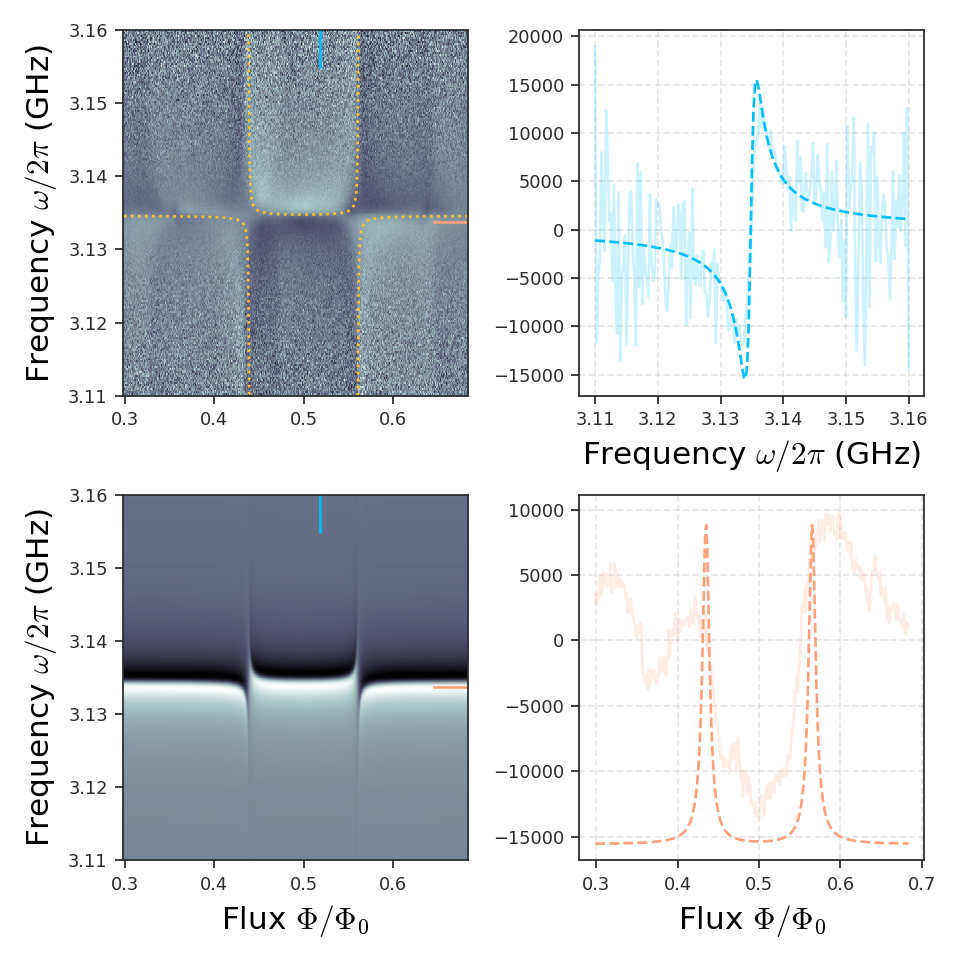

In [475]:
Z = 50
omega_drive = 3.14*GHz * 2*np.pi
# C_k = 0.00008*fF  # guessed 1fF per 10µm of interface -> 2fF but actually it is much mmuch smaller
C_k = 0.3*fF  # guessed 1fF per 10µm of interface -> 2fF but actually it is much mmuch smaller
C_r = 63*fF  # from earlier fits
transmissionScalingPrefactor = - 1/2 * (C_k**2 * omega_drive**2 * Z) / C_r

# Experimental values need to be scaled and offset
# TRANSMISSION_OFFSET = 0.0125
TRANSMISSION_OFFSET = 159_000
EXTRA = -17
TRANSMISSION_MULTIPLIER = 10**((EXTRA -30 -60 + 35 + 30 - 10)/10) #The final -10 is to account for random losses

# SLICES = [80, 100, 110, 125, 176, 260]
XSLICES = 182
YSLICE = 95

# Qubit
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

# Resonator-qubit
(e_low, e_high) = qubit_resonator_spectrum(qubit_f01, resonator_f,
                                           g/1000  # convert to GHz
                                           )

# For master equation simulation
deltaQ = []
deltaR = []
for fq in qubit_f01:
    deltaQ.append(sweep_f - fq)
    deltaR.append(sweep_f - resonator_f)
deltaQ = np.array(deltaQ)*1000  # to convert from GHz to MHz
deltaR = np.array(deltaR)*1000

transmission_function = make_transmission_function(
    Gamma1, GammaPhi, kappa, g)
tMesh = np.transpose(transmission_function(deltaQ, deltaR))


# Plot
fig, ax_arr = plt.subplots(2, 2, figsize=(6, 6))
ax = ax_arr[0][0]
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=plt.cm.bone)
ax.set_ylim([data3d_y[0], data3d_y[-1]])
ax.axvline(data3d_x[XSLICE], 0.9, 1, color="#00bfff")
ax.axhline(data3d_y[YSLICE], 0.9, 1, color=MY_COLOURS["Pink"])
e_low_plot, = ax.plot(FLUX_NUMBER, e_low, color=MY_COLOURS["Orange"], linestyle="dotted")
e_high_plot, = ax.plot(FLUX_NUMBER, e_high, color=MY_COLOURS["Orange"], linestyle="dotted")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")

ax = ax_arr[1][0]
ax.sharex(ax_arr[0][0])
ax.pcolormesh(deltaXMesh, deltaYMesh, tMesh,
              shading='gouraud',
              cmap=plt.cm.bone)
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_xlabel("Flux $\Phi/\Phi_0$")

ax.axvline(data3d_x[XSLICE], 0.9, 1, color="#00bfff")
ax.axhline(data3d_y[YSLICE], 0.9, 1, color=MY_COLOURS["Pink"])

ax = ax_arr[0][1]
ax.plot(data3d_y, data3d_z[:, XSLICE] / TRANSMISSION_MULTIPLIER - TRANSMISSION_OFFSET, color="#00bfff", alpha=0.2)
ax.plot(deltaYMesh[:, XSLICE], transmissionScalingPrefactor * tMesh[:, XSLICE], color="#00bfff", linestyle="--")
ax.set_xlabel("Frequency $\omega/2\pi$ (GHz)")

ax = ax_arr[1][1]
ax.plot(data3d_x, data3d_z[YSLICE, :] / TRANSMISSION_MULTIPLIER - TRANSMISSION_OFFSET, color=MY_COLOURS["Pink"], alpha=0.2)
ax.plot(deltaXMesh[YSLICE, :], transmissionScalingPrefactor * tMesh[YSLICE, :], color=MY_COLOURS["Pink"], linestyle="--")
ax.set_xlabel("Flux $\Phi/\Phi_0$")

plt.tight_layout()

In [476]:
plt.savefig("./data/quantitative-fit-m2.png")

0


<IPython.core.display.Javascript object>


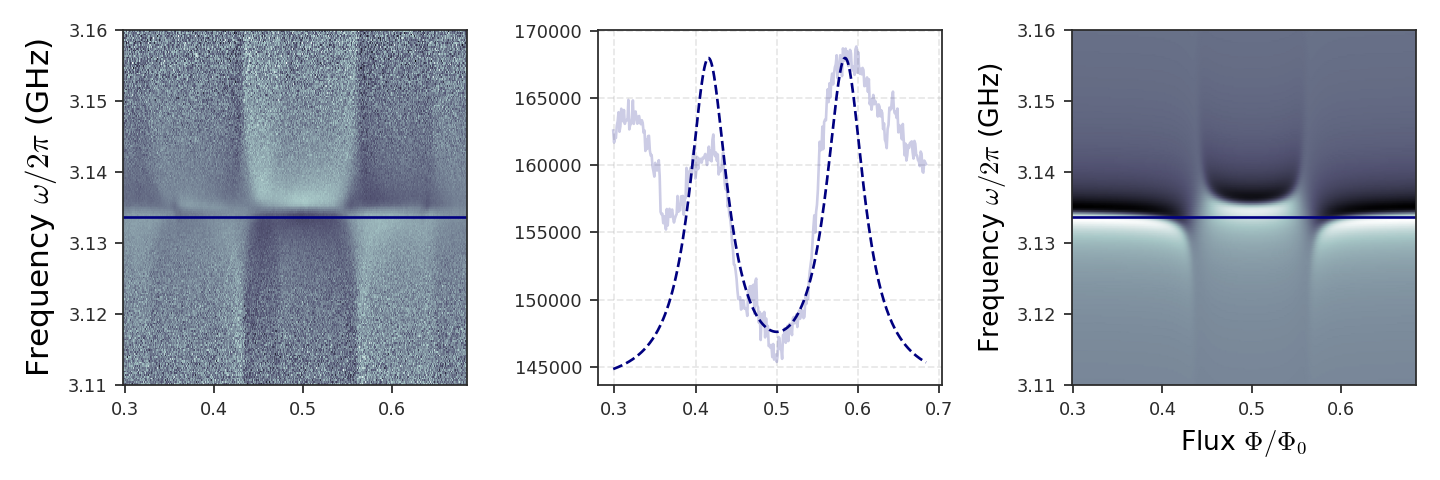

In [170]:
# SLICES = [80, 100, 110, 125, 176, 260]
SLICES = [95
#           ,110
         ]

# Qubit
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

# Resonator-qubit
(e_low, e_high) = qubit_resonator_spectrum(qubit_f01, resonator_f,
                                           g/1000  # convert to GHz
                                           )

# For master equation simulation
deltaQ = []
deltaR = []
for fq in qubit_f01:
    deltaQ.append(sweep_f - fq)
    deltaR.append(sweep_f - resonator_f)
deltaQ = np.array(deltaQ)*1000  # to convert from GHz to MHz
deltaR = np.array(deltaR)*1000

transmission_function = make_transmission_function(
    Gamma1, GammaPhi, kappa, g)
tMesh = np.transpose(transmission_function(deltaQ, deltaR))


# Plot
fig, ax_arr = plt.subplots(1, 3, figsize=(9, 3))
ax = ax_arr[0]
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=plt.cm.bone)
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([data3d_y[0], data3d_y[-1]])

ax = ax_arr[2]
ax.pcolormesh(deltaXMesh, deltaYMesh, tMesh,
              shading='gouraud',
              cmap=plt.cm.bone)
ax.set_xlabel("Flux $\Phi/\Phi_0$", fontsize=12)
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)", fontsize=12)

cmap = plt.cm.jet(np.linspace(0, 1, len(SLICES)))
for idx, slice_idx in enumerate(SLICES):
    ax_arr[0].axhline(data3d_y[slice_idx], color=cmap[idx])
    ax_arr[2].axhline(data3d_y[slice_idx], color=cmap[idx])

    ax_arr[1].plot(data3d_x, data3d_z[slice_idx, :] / TRANSMISSION_MULTIPLIER - TRANSMISSION_OFFSET, color=cmap[idx], alpha=0.2)
    ax_arr[1].plot(deltaXMesh[slice_idx, :], transmissionScalingPrefactor * tMesh[slice_idx, :], color=cmap[idx], linestyle="--")

plt.tight_layout()

In [171]:
plt.savefig("./data/quantitative-fit-m2-slicey.png")

### m=3

In [436]:
FILENAME="./data/2020-07_cqps-single/anticrossing/TiN95_CQPS_C_July12'20_mfield-5_12G_16_data.txt"
# FILENAME="./data/CQPS paper/TiN95_CQPS_C_July12'20_mfield-5_12G_16_data.txt"
OFFSET = 1.4566 - PERIOD/2

resonator_f = 5.12 #GHz
kappa = 6.19 #MHz

# These are in MHz
g = 20
Gamma1 = 13.18 * 2*np.pi
GammaPhi = 0

# Load 3d data
with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = (data3d_x - OFFSET) / PERIOD
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])

# Build meshes and arrays based of the ranges in the file
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)
FLUX_NUMBER = np.linspace(data3d_x[0], data3d_x[-1], len(data3d_x))
sweep_f = np.linspace(data3d_y[0], data3d_y[-1], len(data3d_y))
deltaXMesh, deltaYMesh = np.meshgrid(FLUX_NUMBER, sweep_f)

0


<ipython-input-471-1351ddaecbe7>:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax_arr = plt.subplots(2, 2, figsize=(6, 6))


<IPython.core.display.Javascript object>


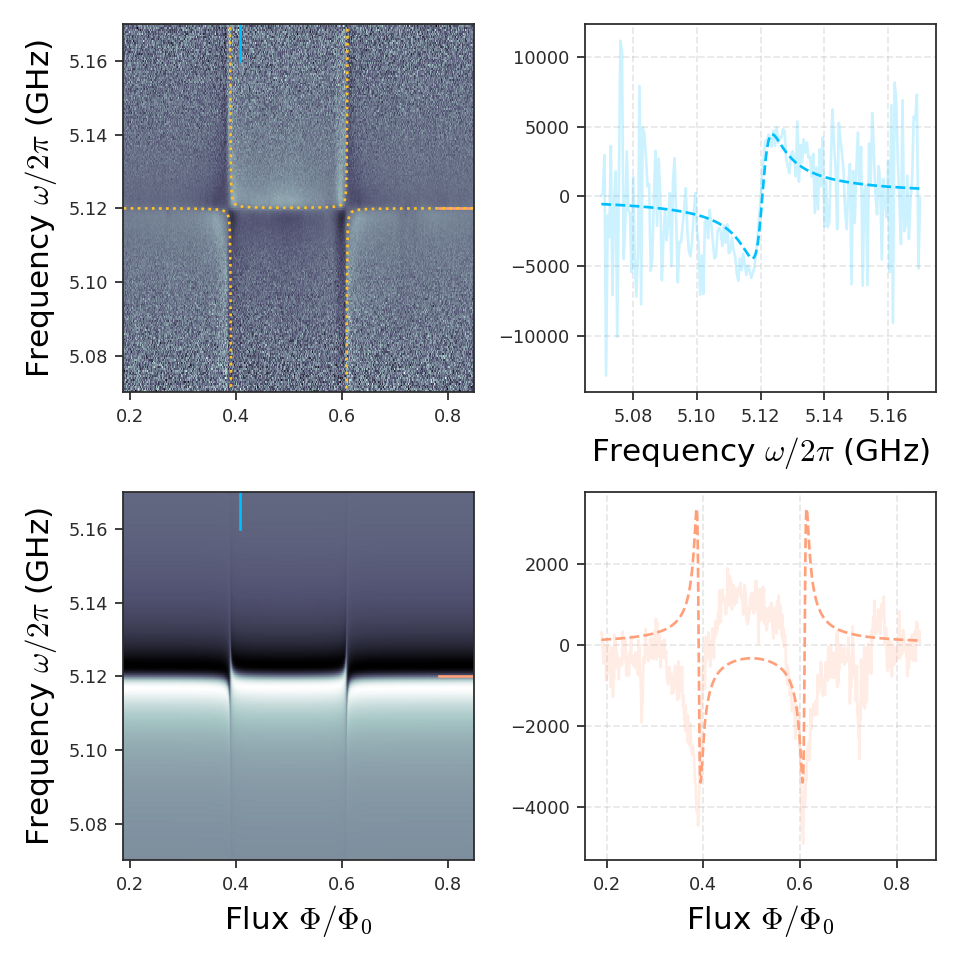

In [471]:
Z = 50
omega_drive = 3.14*GHz * 2*np.pi
C_k = 0.3*fF  # guessed 1fF per 10µm of interface -> 2fF
C_r = 63*fF  # from earlier fits
transmissionScalingPrefactor = - 1/2 * (C_k**2 * omega_drive**2 * Z) / C_r

# Experimental values need to be scaled and offset
# TRANSMISSION_OFFSET = 0.00125
# TRANSMISSION_MULTIPLIER = 10**((-30 - 60 + 35 + 28 + 28 + 28)/10)

TRANSMISSION_OFFSET = 159_000
EXTRA = -17
TRANSMISSION_MULTIPLIER = 10**((EXTRA -30 -60 + 35 + 30 - 10)/10) #The final -10 is to account for random losses

# SLICES = [80, 100, 110, 125, 176, 260]
XSLICE = 200
YSLICE = 100

# Qubit
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

# Resonator-qubit
(e_low, e_high) = qubit_resonator_spectrum(qubit_f01, resonator_f,
                                           g/1000  # convert to GHz
                                           )

# For master equation simulation
deltaQ = []
deltaR = []
for fq in qubit_f01:
    deltaQ.append(sweep_f - fq)
    deltaR.append(sweep_f - resonator_f)
deltaQ = np.array(deltaQ)*1000  # to convert from GHz to MHz
deltaR = np.array(deltaR)*1000

transmission_function = make_transmission_function(
    Gamma1, GammaPhi, kappa, g)
tMesh = np.transpose(transmission_function(deltaQ, deltaR))


# Plot
fig, ax_arr = plt.subplots(2, 2, figsize=(6, 6))
ax = ax_arr[0][0]
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=plt.cm.bone)
ax.set_ylim([data3d_y[0], data3d_y[-1]])
ax.axvline(data3d_x[XSLICE], 0.9, 1, color="#00bfff")
ax.axhline(data3d_y[YSLICE], 0.9, 1, color=MY_COLOURS["Pink"])
e_low_plot, = ax.plot(FLUX_NUMBER, e_low, color=MY_COLOURS["Orange"], linestyle="dotted")
e_high_plot, = ax.plot(FLUX_NUMBER, e_high, color=MY_COLOURS["Orange"], linestyle="dotted")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")

ax = ax_arr[1][0]
ax.sharex(ax_arr[0][0])
ax.pcolormesh(deltaXMesh, deltaYMesh, tMesh,
              shading='gouraud',
              cmap=plt.cm.bone)
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_xlabel("Flux $\Phi/\Phi_0$")

ax.axvline(data3d_x[XSLICE], 0.9, 1, color="#00bfff")
ax.axhline(data3d_y[YSLICE], 0.9, 1, color=MY_COLOURS["Pink"])

ax = ax_arr[0][1]
ax.plot(data3d_y, data3d_z[:, XSLICE] / TRANSMISSION_MULTIPLIER - TRANSMISSION_OFFSET, color="#00bfff", alpha=0.2)
ax.plot(deltaYMesh[:, XSLICE], transmissionScalingPrefactor * tMesh[:, XSLICE], color="#00bfff", linestyle="--")
ax.set_xlabel("Frequency $\omega/2\pi$ (GHz)")

ax = ax_arr[1][1]
ax.plot(data3d_x, data3d_z[YSLICE, :] / TRANSMISSION_MULTIPLIER - TRANSMISSION_OFFSET, color=MY_COLOURS["Pink"], alpha=0.2)
ax.plot(deltaXMesh[YSLICE, :], transmissionScalingPrefactor * tMesh[YSLICE, :], color=MY_COLOURS["Pink"], linestyle="--")
ax.set_xlabel("Flux $\Phi/\Phi_0$")

plt.tight_layout()

In [472]:
plt.savefig("./data/quantitative-fit-m3.png")

0


<IPython.core.display.Javascript object>


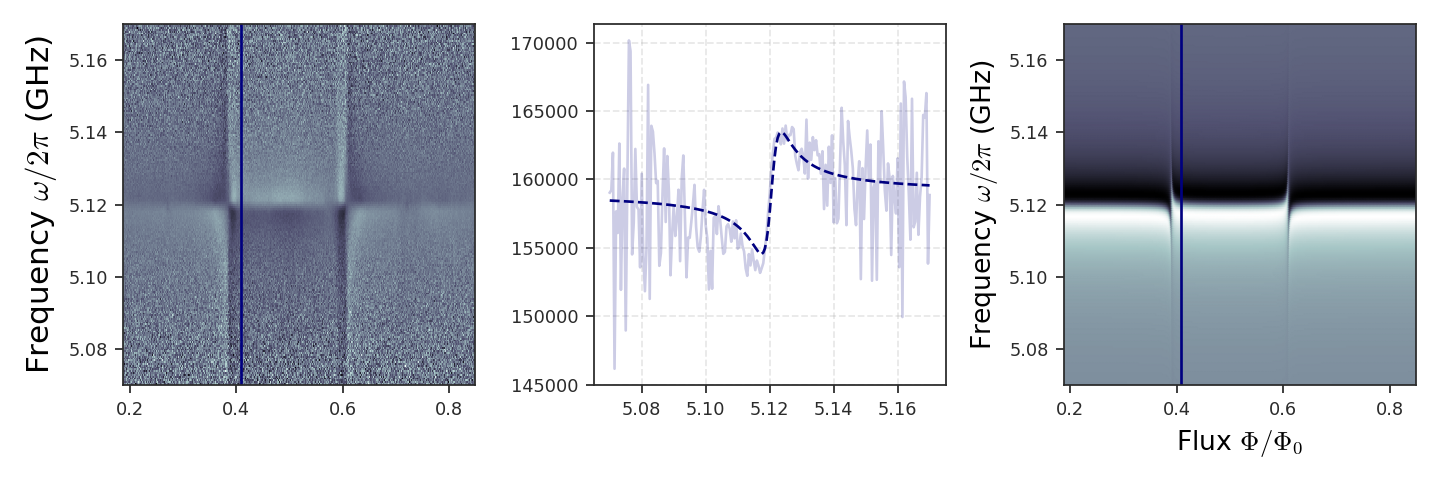

In [437]:
Z = 50
omega_drive = 3.14*GHz * 2*np.pi
C_k = 0.3*fF  # guessed 1fF per 10µm of interface -> 2fF
C_r = 63*fF  # from earlier fits
transmissionScalingPrefactor = - 1/2 * (C_k**2 * omega_drive**2 * Z) / C_r

# Experimental values need to be scaled and offset
# TRANSMISSION_OFFSET = 0.00125
# TRANSMISSION_MULTIPLIER = 10**((-30 - 60 + 35 + 28 + 28 + 28)/10)

TRANSMISSION_OFFSET = 159_000
EXTRA = -17
TRANSMISSION_MULTIPLIER = 10**((EXTRA -30 -60 + 35 + 30 - 10)/10) #The final -10 is to account for random losses


# SLICES = [80, 100, 110, 125, 176, 260]
SLICES = [200]

# Qubit
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

# Resonator-qubit
(e_low, e_high) = qubit_resonator_spectrum(qubit_f01, resonator_f,
                                           g/1000  # convert to GHz
                                           )

# For master equation simulation
deltaQ = []
deltaR = []
for fq in qubit_f01:
    deltaQ.append(sweep_f - fq)
    deltaR.append(sweep_f - resonator_f)
deltaQ = np.array(deltaQ)*1000  # to convert from GHz to MHz
deltaR = np.array(deltaR)*1000

transmission_function = make_transmission_function(
    Gamma1, GammaPhi, kappa, g)
tMesh = np.transpose(transmission_function(deltaQ, deltaR))


# Plot
fig, ax_arr = plt.subplots(1, 3, figsize=(9, 3))
ax = ax_arr[0]
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=plt.cm.bone)
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([data3d_y[0], data3d_y[-1]])

ax = ax_arr[2]
ax.pcolormesh(deltaXMesh, deltaYMesh, tMesh,
              shading='gouraud',
              cmap=plt.cm.bone)
ax.set_xlabel("Flux $\Phi/\Phi_0$", fontsize=12)
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)", fontsize=12)

cmap = plt.cm.jet(np.linspace(0, 1, len(SLICES)))
for idx, slice_idx in enumerate(SLICES):
    ax_arr[0].axvline(data3d_x[slice_idx], color=cmap[idx])
    ax_arr[2].axvline(data3d_x[slice_idx], color=cmap[idx])

    SEPARATION = idx * 0.002
    ax_arr[1].plot(data3d_y, SEPARATION + data3d_z[:, slice_idx] /
                   TRANSMISSION_MULTIPLIER, color=cmap[idx], alpha=0.2)
    ax_arr[1].plot(deltaYMesh[:, slice_idx], SEPARATION + TRANSMISSION_OFFSET +
                   transmissionScalingPrefactor * tMesh[:, slice_idx], color=cmap[idx], linestyle="--")

plt.tight_layout()

In [132]:
plt.savefig("./data/quantitative-fit-m3-slice.png")

0


<IPython.core.display.Javascript object>


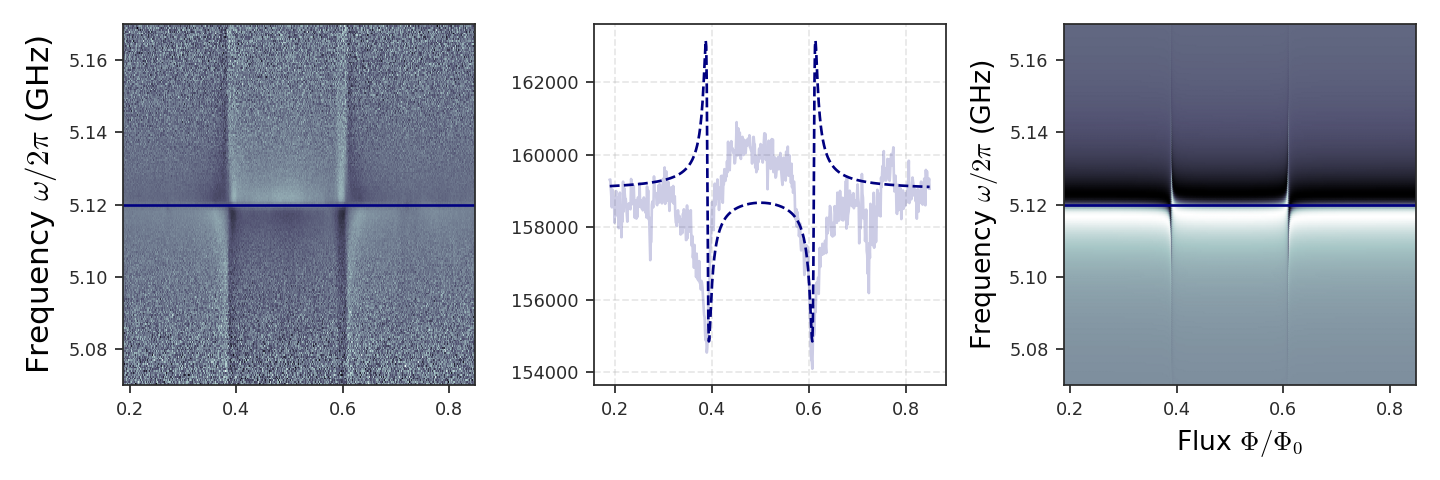

In [162]:
# SLICES = [80, 100, 110, 125, 176, 260]

resonator_f = 5.12 #GHz
kappa = 6.19 #MHz

# These are in MHz
g = 20
Gamma1 = 20
GammaPhi = 0

SLICES = [
#     95,
#     110
    100
         ]

# Qubit
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

# Resonator-qubit
(e_low, e_high) = qubit_resonator_spectrum(qubit_f01, resonator_f,
                                           g/1000  # convert to GHz
                                           )

# For master equation simulation
deltaQ = []
deltaR = []
for fq in qubit_f01:
    deltaQ.append(sweep_f - fq)
    deltaR.append(sweep_f - resonator_f)
deltaQ = np.array(deltaQ)*1000  # to convert from GHz to MHz
deltaR = np.array(deltaR)*1000

transmission_function = make_transmission_function(
    Gamma1, GammaPhi, kappa, g)
tMesh = np.transpose(transmission_function(deltaQ, deltaR))


# Plot
fig, ax_arr = plt.subplots(1, 3, figsize=(9, 3))
ax = ax_arr[0]
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=plt.cm.bone)
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([data3d_y[0], data3d_y[-1]])

ax = ax_arr[2]
ax.pcolormesh(deltaXMesh, deltaYMesh, tMesh,
              shading='gouraud',
              cmap=plt.cm.bone)
ax.set_xlabel("Flux $\Phi/\Phi_0$", fontsize=12)
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)", fontsize=12)

cmap = plt.cm.jet(np.linspace(0, 1, len(SLICES)))
for idx, slice_idx in enumerate(SLICES):
    ax_arr[0].axhline(data3d_y[slice_idx], color=cmap[idx])
    ax_arr[2].axhline(data3d_y[slice_idx], color=cmap[idx])

    SEPARATION = idx * 0.001
    ax_arr[1].plot(data3d_x, SEPARATION + data3d_z[slice_idx, :] /
                   TRANSMISSION_MULTIPLIER, color=cmap[idx], alpha=0.2)
    ax_arr[1].plot(deltaXMesh[slice_idx, :], SEPARATION + TRANSMISSION_OFFSET +
                   transmissionScalingPrefactor * tMesh[slice_idx, :], color=cmap[idx], linestyle="--")

plt.tight_layout()

In [163]:
plt.savefig("./data/quantitative-fit-m3-slicey.png")

## Evaluating $\kappa$
\begin{equation}
\kappa \approx \frac{2ZC_{k}^{2}\omega^{2}}{C_r}
\end{equation}

In [66]:
L_per_unit_length
C_per_unit_length = 10**(-10)
f = 5*GHz

Z = np.sqrt(L_per_unit_length/C_per_unit_length)
C_rt = 20*um * C_per_unit_length
C_r = 1140*um * C_per_unit_length

kappa = 2 * Z * C_rt**2 * f**2 / C_r
kappa / MHz

2.4810764252159556

In [68]:
# Estimateing gamma
C_qr = 3*um * C_per_unit_length
Es = 1 *GHz * h
Vr  = np.sqrt(h*f/C_r)
Vq = np.pi * Es / (2*e) 

Vq * C_qr * Vr / h / MHz

15.894166759957692

# Resistance

In [268]:
data[-1,0]

0.291

<IPython.core.display.Javascript object>


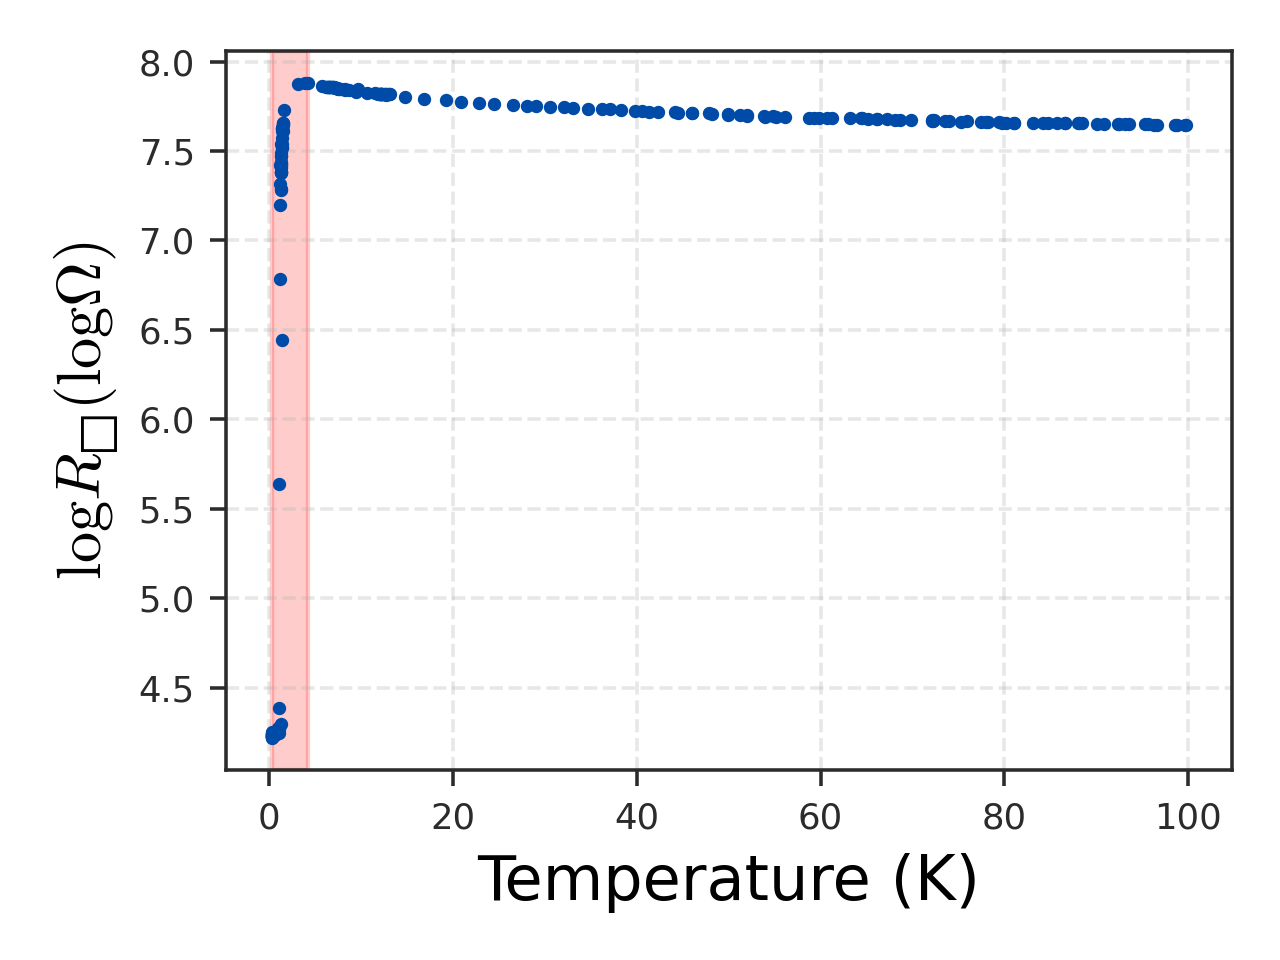

In [11]:
FILENAME = "./data/2020-07_cqps-single/resistance/TiN95_CQPS_DC_Apr12'19_Tdep_extract.txt"
data = np.loadtxt(FILENAME)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(data[250:, 0], np.log(data[250:, 1]), linestyle = "", marker="o")
# ax.plot(data[250:, 0], data[250:, 1], linestyle = "", marker="o")

ax.set_ylabel("$\log{R_{□}} (\log{\Omega})$")
ax.set_xlabel("Temperature (K)")
ax.axvspan(data[388,0], data[-1,0], color='red', alpha=0.2)
plt.tight_layout()

plt.savefig(FILENAME.replace(".txt", ".pdf"))

<IPython.core.display.Javascript object>


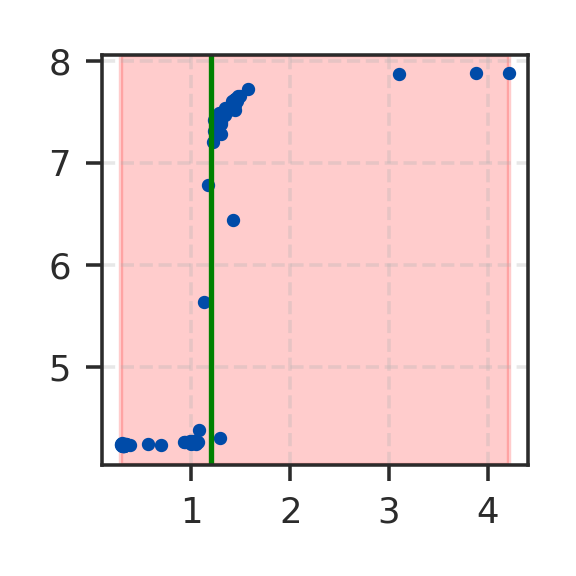

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.8))
ax.plot(data[388:, 0], np.log(data[388:, 1]), linestyle = "", marker="o")
# ax.set_ylabel("$R_{□} (\Omega)$")
# ax.set_xlabel("Temperature (K)")
plt.tight_layout()
plt.xticks(np.arange(0, 5, 1))
ax.axvline(1.2, color = 'green')
ax.axvspan(data[388,0], data[-1,0], color='red', alpha=0.2)

plt.savefig(FILENAME.replace(".txt", "_insert.pdf"))

# Integrating profile

In [ ]:
TRIANGLE_IN = [
    # Narrow first
    (1.4, 0.1), 
    # Then flat bar
    (0.47, 0.1)]
TRIANGLE_OUT = [
    # Flat bar
    (0, 0.1),
    (0.47, 0.1),
    # Triangle out
    (1.4, 1.4)
]
SIDE_CONSTRICTION = [
    # Narrow to constriction
    (0, SIDE_CONSTRICTION_WIDTH),
    (0.05, SIDE_CONSTRICTION_WIDTH)
]

def create_loop_profile(loop_profile: list):
    position = [0]
    width = [1.4]
    
    for (l, w) in loop_profile:
        position.append(position[-1] + l)
        width.append(w)
    return (position, width)

## 8nm

In [374]:
constriction = 0.008
# Then, to evaluate we chop up into separate blocks
(
    # Wide sections
    (0.55 + 5.15 + 7.6 + 3.8 + 1.85) / 1.4
    +
    # Narrowing
    (0.47 + 0.47) / 0.1
    # Constrictions
    + (0.05) / constriction
    # Triangles
    + 2 * 1.4 * np.log(1.4/0.1) / (1.4 - 0.1)
)

34.86983776488562

## 8.5nm

In [375]:
constriction = 0.0085
# Then, to evaluate we chop up into separate blocks
(
    # Wide sections
    (0.55 + 6.3 + 7.6 + 5 + 1.85) / 1.4
    +
    # Narrowing
    (0.47 + 0.47) / 0.1
    # Constrictions
    + (0.05) / constriction
    # Triangles
    + 2 * 1.4 * np.log(1.4/0.1) / (1.4 - 0.1)
)

36.18076213463351

## 9nm

In [376]:
constriction = 0.009
# Then, to evaluate we chop up into separate blocks
(
    # Wide sections
    (0.55 + 6.65 + 7.6 + 5.4 + 1.85) / 1.4
    +
    # Narrowing
    (0.47 + 0.47) / 0.1
    # Constrictions
    + (0.05) / constriction
    # Triangles
    + 2 * 1.4 * np.log(1.4/0.1) / (1.4 - 0.1)
)

36.38967903472688

## 9.5nm

In [378]:
constriction = 0.0095
# Then, to evaluate we chop up into separate blocks
(
    # Wide sections
    (0.55 + 7.8 + 7.6 + 6.5 + 1.85) / 1.4
    +
    # Narrowing
    (0.47 + 0.47) / 0.1
    # Constrictions
    + (0.05) / constriction
    # Triangles
    + 2 * 1.4 * np.log(1.4/0.1) / (1.4 - 0.1)
)

37.70442423105103

# 10nm

In [379]:
constriction = 0.01
# Then, to evaluate we chop up into separate blocks
(
    # Wide sections
    (0.55 + 8.15 + 7.6 + 6.8 + 1.85) / 1.4
    +
    # Narrowing
    (0.47 + 0.47) / 0.1
    # Constrictions
    + (0.05) / constriction
    # Triangles
    + 2 * 1.4 * np.log(1.4/0.1) / (1.4 - 0.1)
)

37.9055520505999

## 10.5nm

In [380]:
constriction = 0.0105
# Then, to evaluate we chop up into separate blocks
(
    # Wide sections
    (0.55 + 8.55 + 7.6 + 7.3 + 1.85) / 1.4
    +
    # Narrowing
    (0.47 + 0.47) / 0.1
    # Constrictions
    + (0.05) / constriction
    # Triangles
    + 2 * 1.4 * np.log(1.4/0.1) / (1.4 - 0.1)
)

38.310313955361806

## 12nm

In [381]:
constriction = 0.012
# Then, to evaluate we chop up into separate blocks
(
    # Wide sections
    (4.5 + 4.4 + 12.9 + 5.65 + 3.2) / 1.4
    +
    # Narrowing
    (0.47 + 0.47) / 0.1
    # Constrictions
    + (0.05) / constriction
    # Triangles
    + 2 * 1.4 * np.log(1.4/0.1) / (1.4 - 0.1)
)

41.143647288695135

## 13.5nm

In [382]:
constriction = 0.0135
# Then, to evaluate we chop up into separate blocks
(
    # Wide sections
    (4.5 + 5 + 12.9 + 6.4 + 3.2) / 1.4
    +
    # Narrowing
    (0.47 + 0.47) / 0.1
    # Constrictions
    + (0.05) / constriction
    # Triangles
    + 2 * 1.4 * np.log(1.4/0.1) / (1.4 - 0.1)
)

41.64497004001788

In [383]:
Phi0

2.0749999999999996e-15